In [ ]:
!pip install optuna
!pip install --upgrade scikit-learn # 不更新的話mean_absolute_percentage_error可能會import不了

In [37]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold, cross_val_score
from sklearn import preprocessing
import optuna
import functools
import lightgbm as lgb
from google.colab import files
import pylab
from sklearn.ensemble import IsolationForest, RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [38]:
upload = files.upload()
upload = files.upload()

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Saving train.csv to train (1).csv


Saving test.csv to test (1).csv


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1095 non-null   int64  
 1   MSSubClass     1095 non-null   int64  
 2   MSZoning       1095 non-null   object 
 3   LotFrontage    904 non-null    float64
 4   LotArea        1095 non-null   int64  
 5   Street         1095 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1095 non-null   object 
 8   LandContour    1095 non-null   object 
 9   Utilities      1095 non-null   object 
 10  LotConfig      1095 non-null   object 
 11  LandSlope      1095 non-null   object 
 12  Neighborhood   1095 non-null   object 
 13  Condition1     1095 non-null   object 
 14  Condition2     1095 non-null   object 
 15  BldgType       1095 non-null   object 
 16  HouseStyle     1095 non-null   object 
 17  OverallQual    1095 non-null   int64  
 18  OverallC

In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             365 non-null    int64  
 1   MSSubClass     365 non-null    int64  
 2   MSZoning       365 non-null    object 
 3   LotFrontage    297 non-null    float64
 4   LotArea        365 non-null    int64  
 5   Street         365 non-null    object 
 6   Alley          21 non-null     object 
 7   LotShape       365 non-null    object 
 8   LandContour    365 non-null    object 
 9   Utilities      365 non-null    object 
 10  LotConfig      365 non-null    object 
 11  LandSlope      365 non-null    object 
 12  Neighborhood   365 non-null    object 
 13  Condition1     365 non-null    object 
 14  Condition2     365 non-null    object 
 15  BldgType       365 non-null    object 
 16  HouseStyle     365 non-null    object 
 17  OverallQual    365 non-null    int64  
 18  OverallCon

In [41]:
def show_na(data):
  total = data.isnull().sum().sort_values(ascending = False)
  percent = (round(data.isnull().sum()/data.isnull().count(), 3)).sort_values(ascending = False)
  missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
  missing_data = missing_data[missing_data['Total'] > 0]
  missing_data['type'] = [data.dtypes[i] for i in missing_data.index]
  print(missing_data)

show_na(train)

              Total  Percent     type
PoolQC         1091    0.996   object
MiscFeature    1054    0.963   object
Alley          1025    0.936   object
Fence           888    0.811   object
FireplaceQu     517    0.472   object
LotFrontage     191    0.174  float64
GarageType       67    0.061   object
GarageCond       67    0.061   object
GarageYrBlt      67    0.061  float64
GarageFinish     67    0.061   object
GarageQual       67    0.061   object
BsmtExposure     29    0.026   object
BsmtFinType2     29    0.026   object
BsmtFinType1     28    0.026   object
BsmtCond         28    0.026   object
BsmtQual         28    0.026   object
MasVnrArea        7    0.006  float64
MasVnrType        7    0.006   object


In [42]:
nalist = ['Alley', 'MiscFeature', 'PoolQC', 'Fence', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'GarageType', 
      'GarageCond', 'GarageFinish', 'GarageQual'] # 這個NA代表房子真的沒有那個東西，例如車庫
for ele in nalist:
  train[ele].fillna('NA', inplace=True)

# 這兩個NA比例較小就隨便填一下
train['MasVnrType'] = train['MasVnrType'].fillna(train['MasVnrType'].mode()[0])
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'][train['MasVnrType'] == 'None'].median())
# 針對NA比例較大且NA原因未知的變數用一個新的變數標記
train['LotFrontage_na'] = 0
train['LotFrontage_na'][train['LotFrontage'].isnull()] = 1
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].median()) # 真的沒有車庫，但因為是連續行無法直接塞NA

In [43]:
show_na(test)

              Total  Percent     type
PoolQC          362    0.992   object
MiscFeature     352    0.964   object
Alley           344    0.942   object
Fence           291    0.797   object
FireplaceQu     173    0.474   object
LotFrontage      68    0.186  float64
GarageCond       14    0.038   object
GarageType       14    0.038   object
GarageYrBlt      14    0.038  float64
GarageFinish     14    0.038   object
GarageQual       14    0.038   object
BsmtFinType1      9    0.025   object
BsmtExposure      9    0.025   object
BsmtCond          9    0.025   object
BsmtQual          9    0.025   object
BsmtFinType2      9    0.025   object
Electrical        1    0.003   object
MasVnrArea        1    0.003  float64
MasVnrType        1    0.003   object


In [44]:
for ele in nalist:
  test[ele].fillna('NA', inplace=True)

test['MasVnrType'] = test['MasVnrType'].fillna(test['MasVnrType'].mode()[0])
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])
test['MasVnrArea'] = test['MasVnrArea'].fillna(test['MasVnrArea'][test['MasVnrType'] == 'None'].median())
test['LotFrontage_na'] = 0
test['LotFrontage_na'][test['LotFrontage'].isnull()] = 1
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].median())
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['GarageYrBlt'].median())

In [45]:
train_test = pd.concat([train, test])
train_test.drop(['FireplaceQu', 'Id'], axis=1, inplace=True)

In [46]:
# 建造年份轉屋齡
train_test['YearBuilt'] = [2021-i for i in train_test['YearBuilt']]
train_test['YearRemodAdd'] = [2021-i for i in train_test['YearRemodAdd']]
train_test['GarageYrBlt'] = [2021-i for i in train_test['GarageYrBlt']]
train_test['totalsf'] = train_test['1stFlrSF'] + train_test['2ndFlrSF'] + train_test['TotalBsmtSF']
train_test['totalporch'] = train_test['EnclosedPorch'] + train_test['OpenPorchSF'] + train_test['ScreenPorch'] + train_test['3SsnPorch']
train_test['Total_Bathrooms'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) + train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))

In [47]:
train_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,FireplaceQu_na,LotFrontage_na,totalsf,totalporch,Total_Bathrooms
0,60,RL,60.0,21930,Pave,NA,IR3,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,2Story,5,5,16,16,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,Unf,0,Unf,0,732,732,GasA,Ex,Y,SBrkr,734,1104,0,1838,0,0,2,1,4,1,TA,7,Typ,1,BuiltIn,16.0,Fin,2,372,TA,TA,Y,100,40,0,0,0,0,NA,NA,NA,0,7,2006,WD,Normal,192140,0.0,0,2570,40,2.5
1,60,RL,68.0,10769,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,14,14,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,20,Unf,0,846,866,GasA,Ex,Y,SBrkr,866,902,0,1768,0,0,2,1,3,1,Gd,7,Typ,0,Attchd,14.0,RFn,2,578,TA,TA,Y,144,105,0,0,0,0,NA,NA,NA,0,4,2009,WD,Normal,212000,1.0,0,2634,105,2.5
2,120,RL,34.0,4590,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,Twnhs,1Story,8,5,15,15,Gable,CompShg,VinylSd,VinylSd,Stone,108.0,Gd,TA,PConc,Gd,Gd,Mn,GLQ,24,Unf,0,1530,1554,GasA,Ex,Y,SBrkr,1554,0,0,1554,0,0,2,0,2,1,Gd,6,Typ,1,Attchd,15.0,RFn,2,627,TA,TA,Y,156,73,0,0,0,0,NA,NA,NA,0,8,2007,WD,Normal,209500,0.0,0,3108,73,2.0
3,50,RM,60.0,9600,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,5,8,96,27,Gambrel,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,TA,TA,Mn,Unf,0,Unf,0,702,702,GasA,Gd,Y,SBrkr,842,630,0,1472,0,0,1,0,3,1,Gd,6,Typ,0,Detchd,96.0,Unf,1,250,TA,Fa,P,0,0,84,0,0,0,NA,GdWo,NA,0,7,2007,WD,Normal,125000,1.0,0,2174,84,1.0
4,80,RL,94.0,7819,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,SLvl,6,5,45,45,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Av,ALQ,422,BLQ,127,480,1029,GasA,TA,Y,SBrkr,1117,0,0,1117,1,0,1,0,3,1,TA,6,Typ,1,Detchd,45.0,Unf,2,672,TA,TA,Y,144,0,0,0,0,0,NA,MnPrv,NA,0,3,2010,WD,Abnorml,107000,0.0,0,2146,0,2.0


In [48]:
intlist=['LotFrontage', 'LotArea', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea' ,'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'MiscVal', 'totalsf', 'totalporch']
len(intlist)

24

In [49]:
# 針對連續變數中很多為0的變數增加標記變數
zero_list = []
for ele in intlist:
  if(train_test[ele].value_counts().keys()[0] == 0):
    if(train_test[ele].value_counts().tolist()[0]/len(train_test) > 0.1):
      zero_list.append(ele)

for ele in zero_list:
  name = ele + '_0'
  train_test[name] = train_test[ele].apply(lambda x: 1 if x > 0 else 0)

In [50]:
train = train_test[:1095]
test = train_test[1095:]
y_ori = np.log1p(train['SalePrice'])
ytest = test['SalePrice']

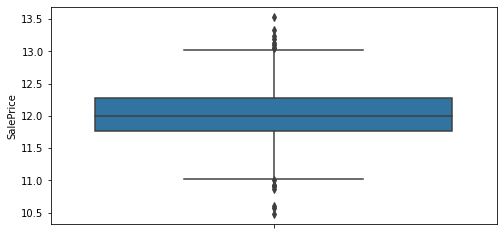

In [51]:
f, ax = plt.subplots(figsize = (8, 4))
fig = sns.boxplot(y = y_ori)

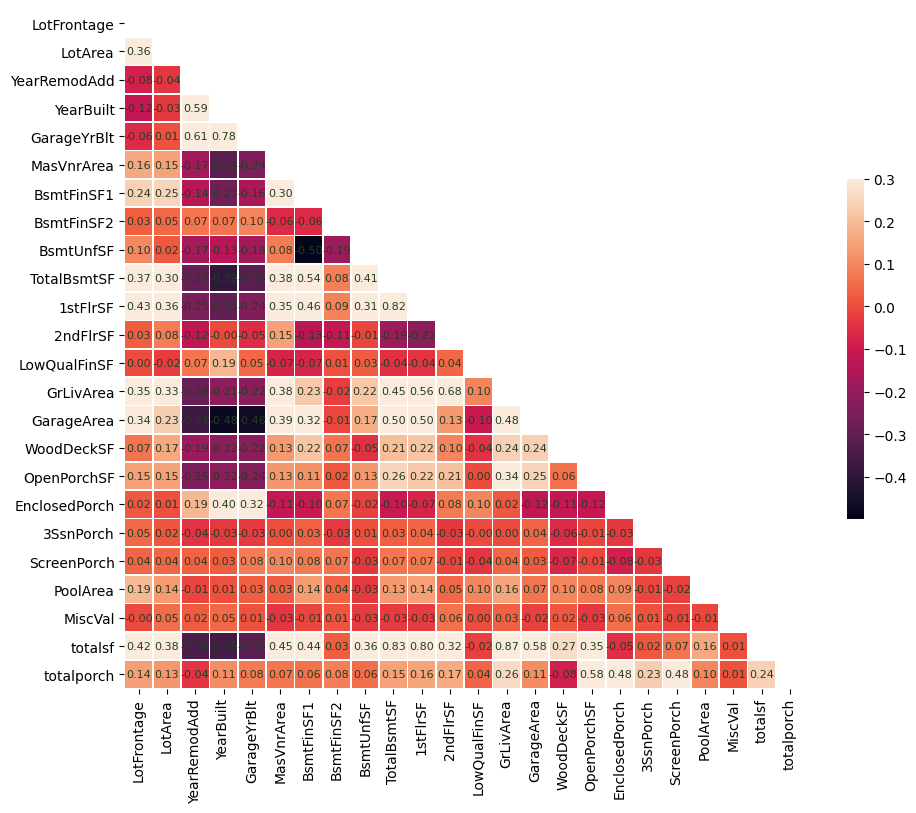

In [52]:
dcorr = train[intlist].corr(method = 'pearson')
plt.figure(figsize=(11, 9), dpi = 100)
sns.heatmap(data=dcorr, vmax=0.3, annot = True, fmt = ".2f", annot_kws = {'size':8, 'weight':'normal', 'color':'#253D24'},
      mask=np.triu(np.ones_like(dcorr, dtype = np.bool)), square = True, linewidths = .5, cbar_kws = {"shrink":.5})

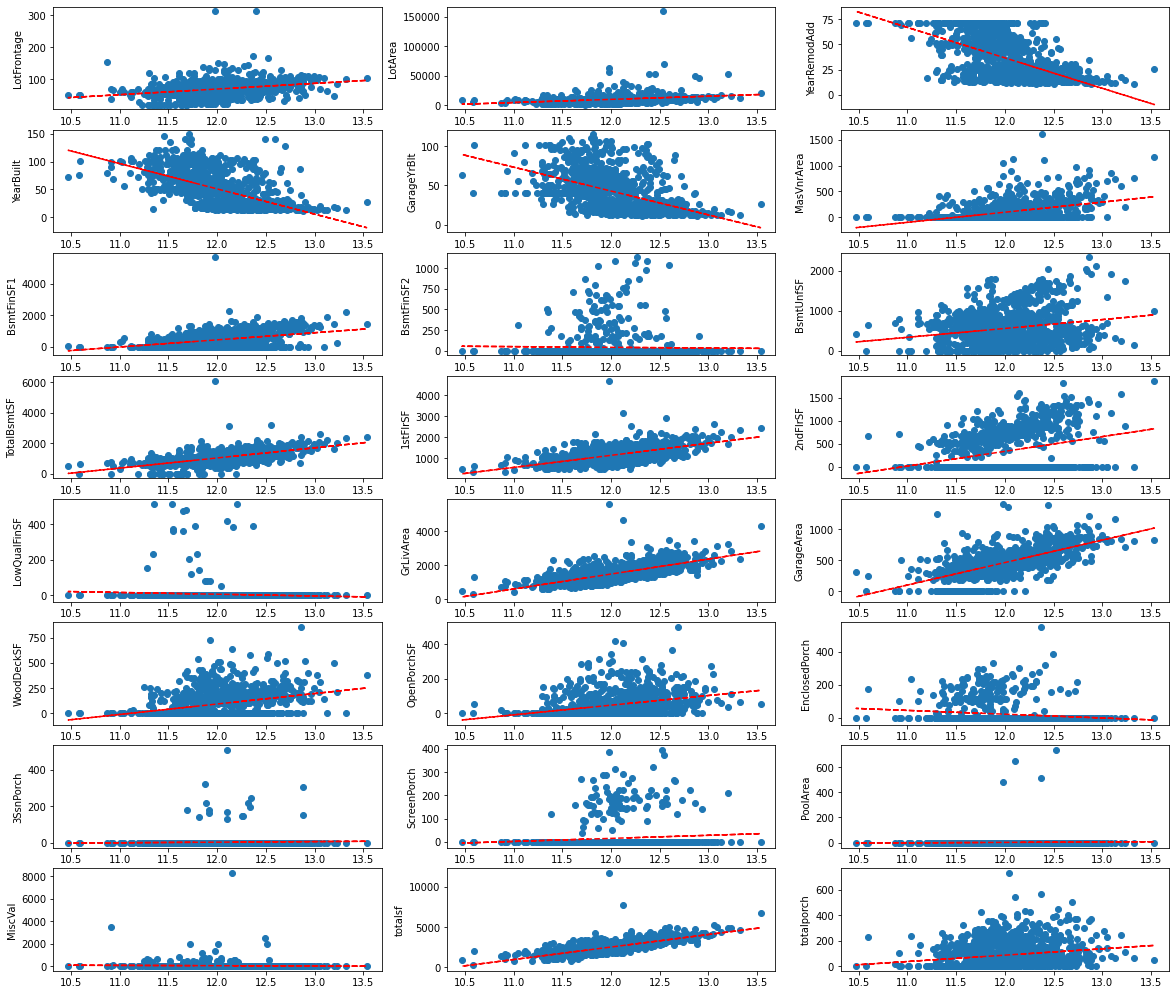

In [53]:
plt.figure(figsize=(20, 20))
for idx, col in enumerate(intlist):
  plt.subplot(9, 3, idx+1)    
  var = col
  pylab.plot(y_ori, train[var], 'o')
  z = np.polyfit(y_ori, train[var], 1)
  p = np.poly1d(z)
  pylab.plot(y_ori ,p(y_ori), 'r--')
  pylab.ylabel(var)

In [54]:
# 拿掉趨勢線與價格沒有太大關係的連續型變數
int_drop_list = ['BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'PoolArea', 'MiscVal']
train_test.drop(int_drop_list, axis = 1, inplace = True)
intlist = [ele for ele in intlist if ele not in int_drop_list]

In [55]:
catlist = list(set(train_test.columns).difference(set(intlist)))
catlist.remove("SalePrice")
len(catlist)

72

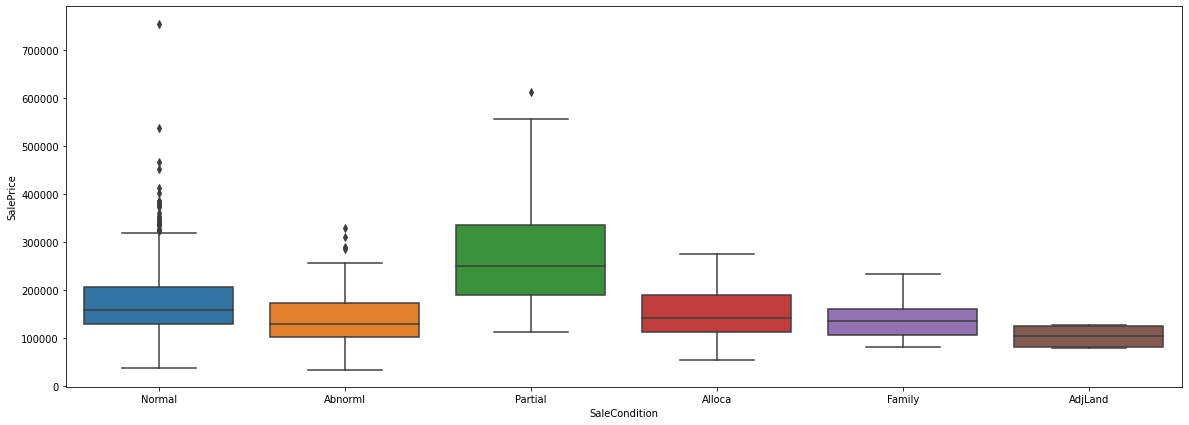

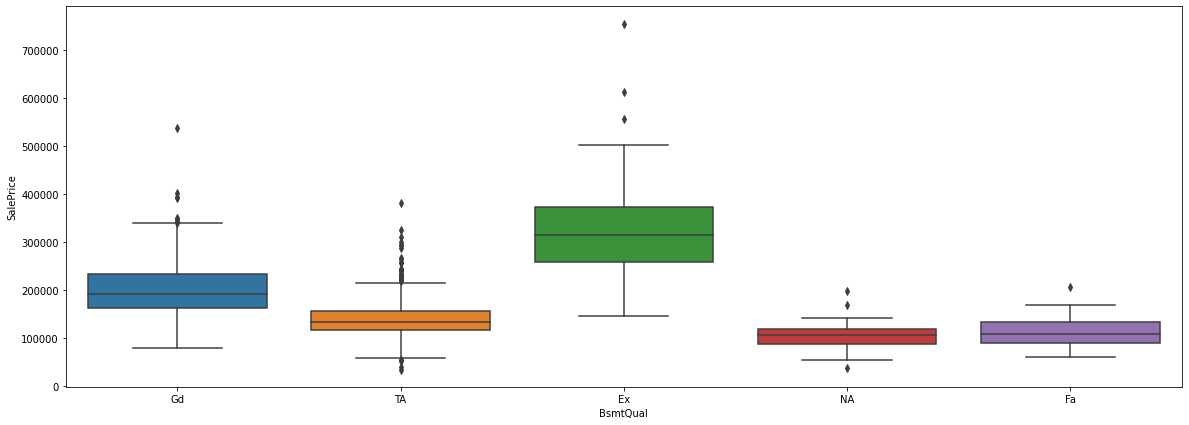

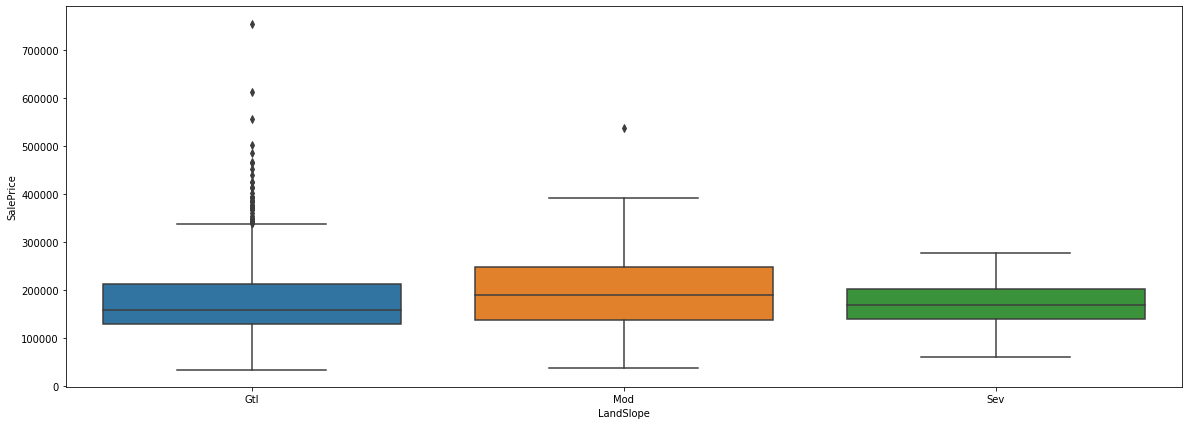

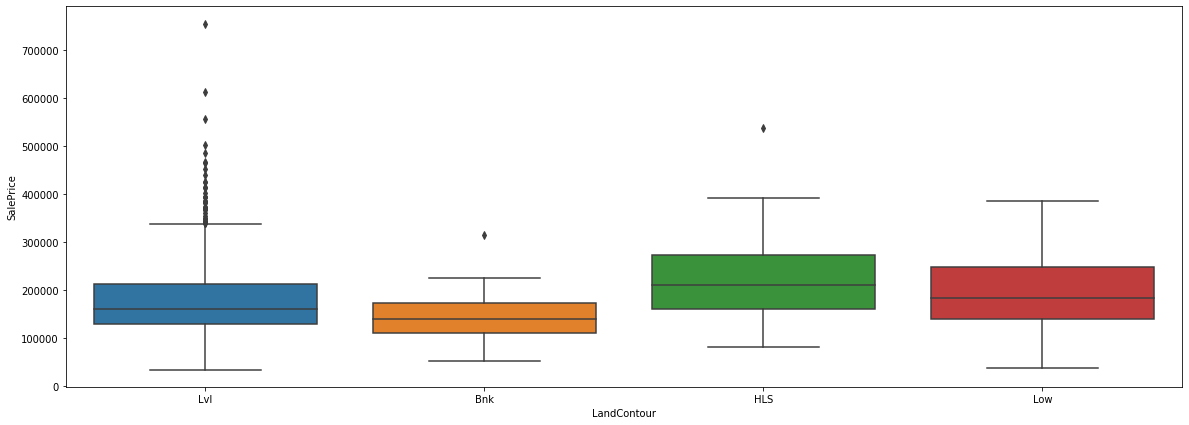

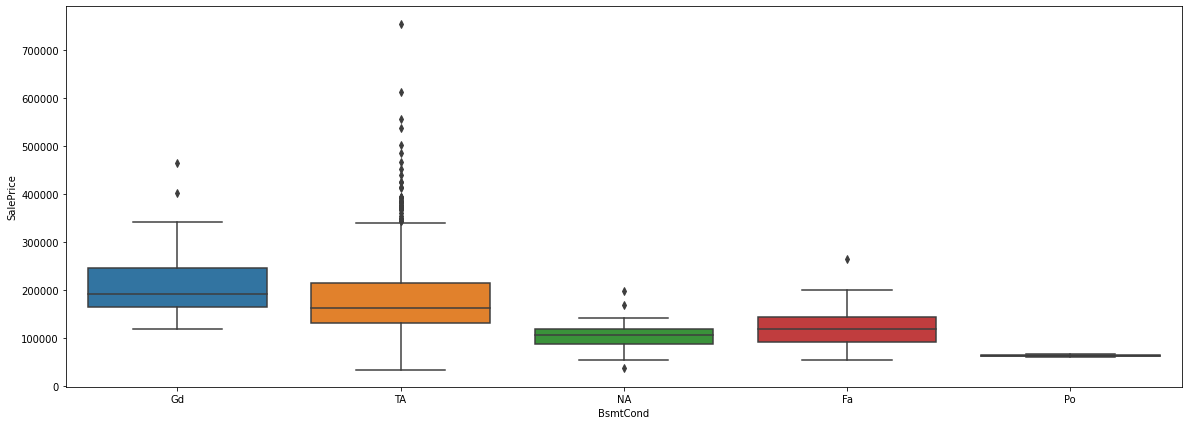

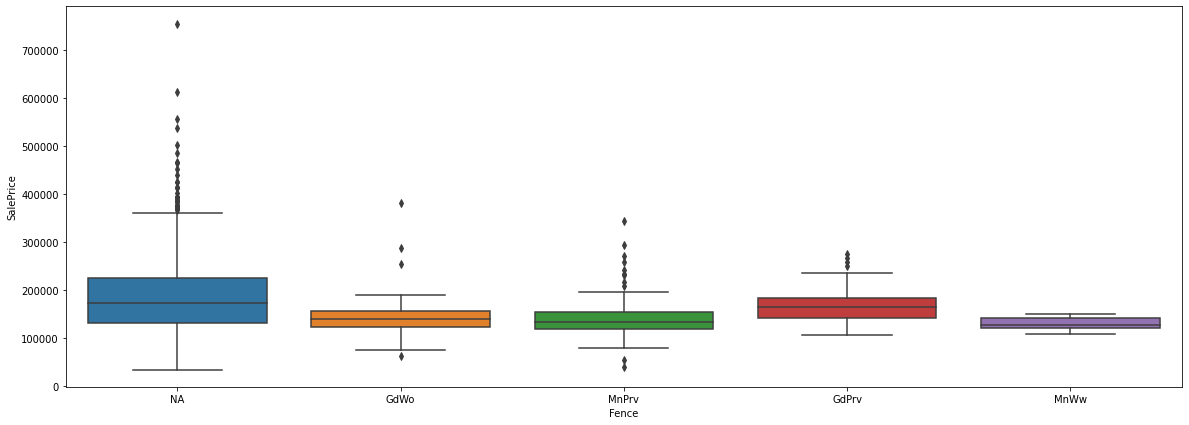

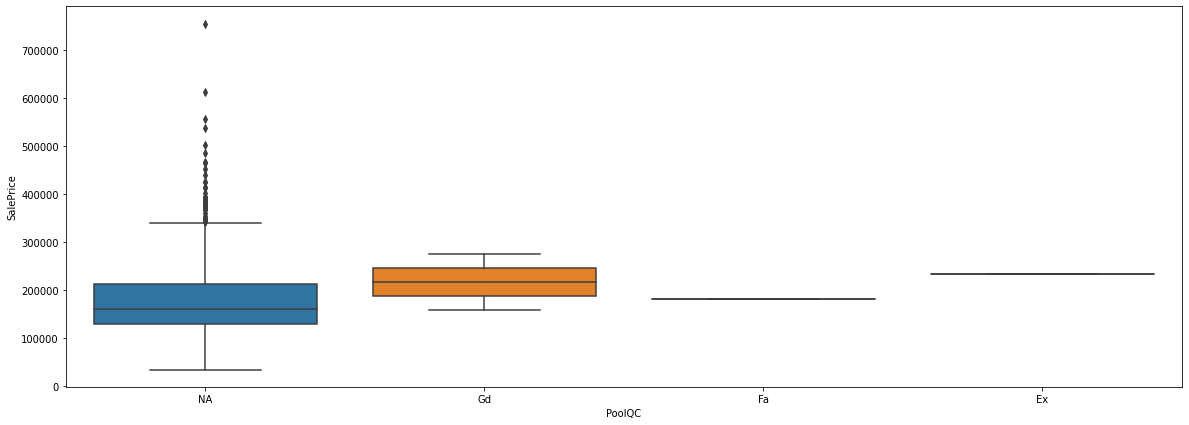

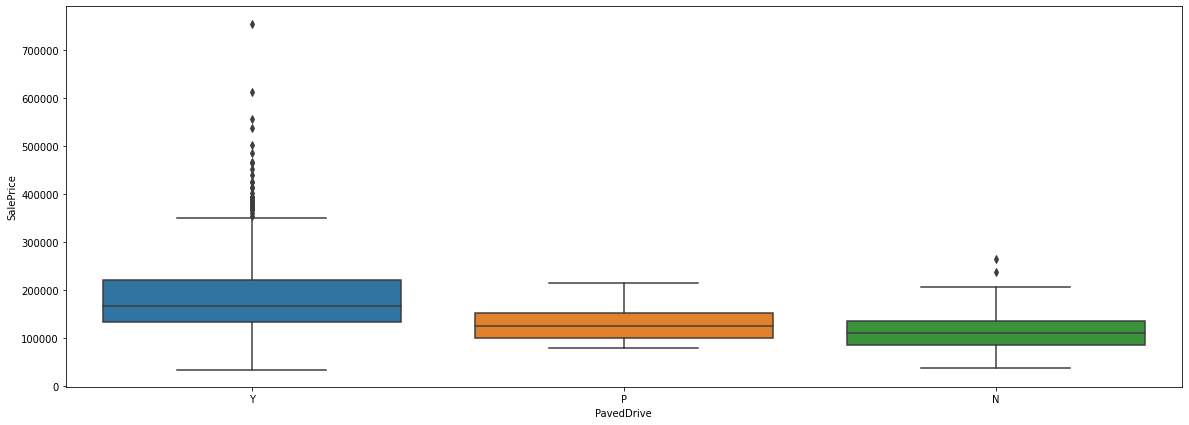

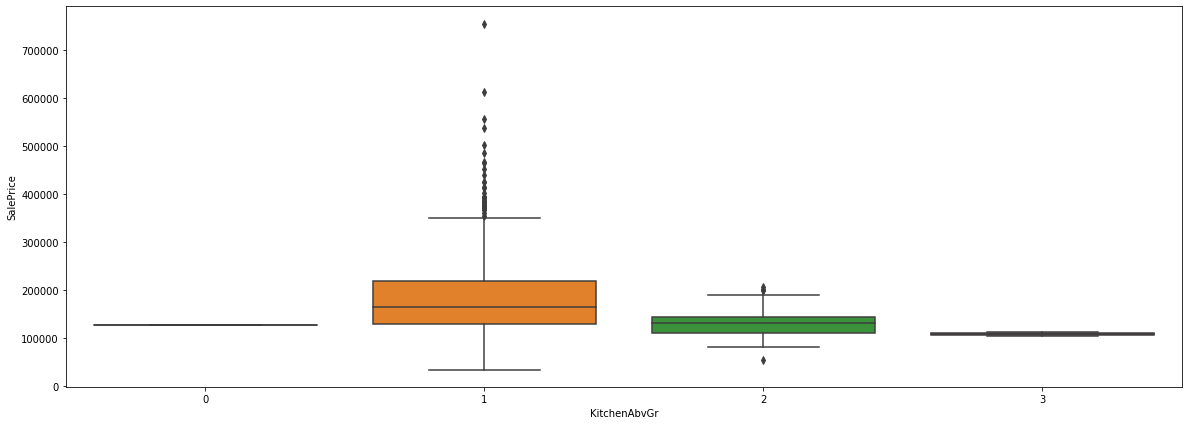

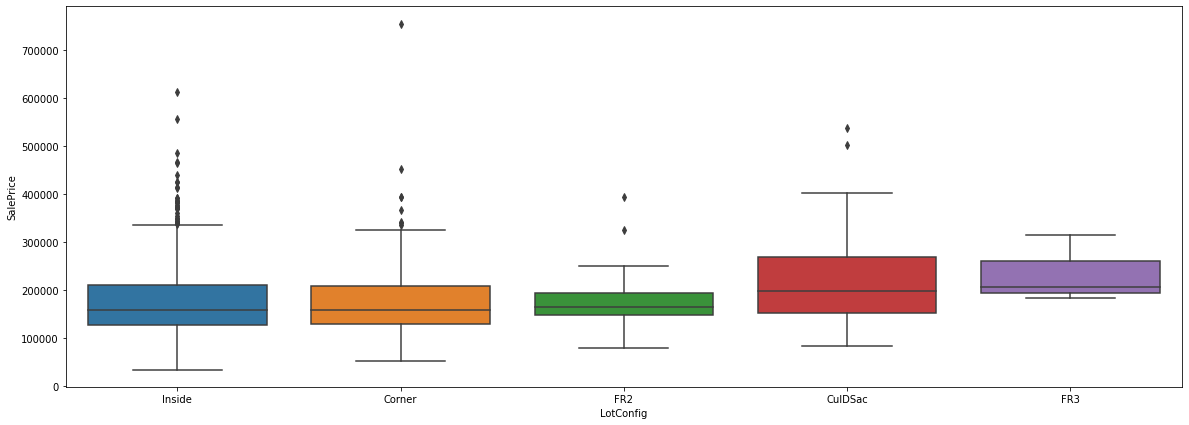

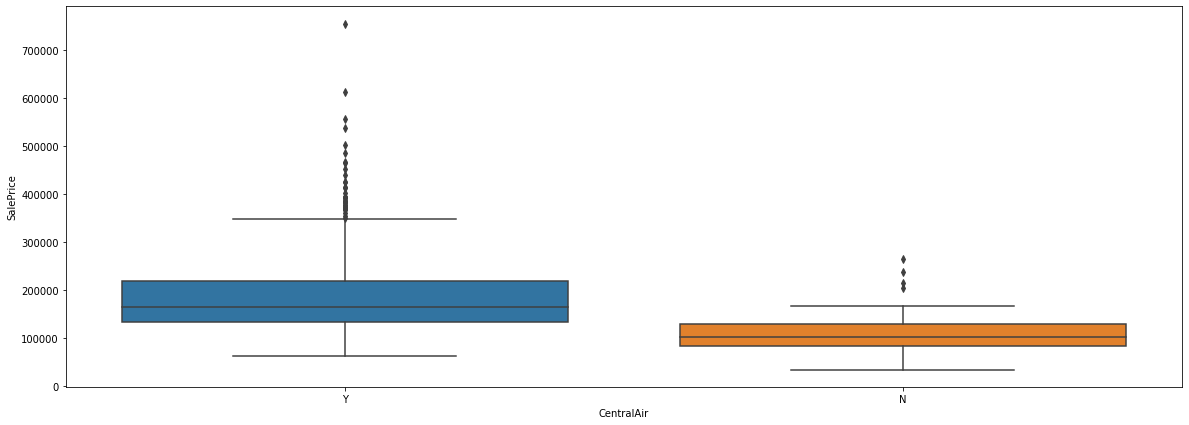

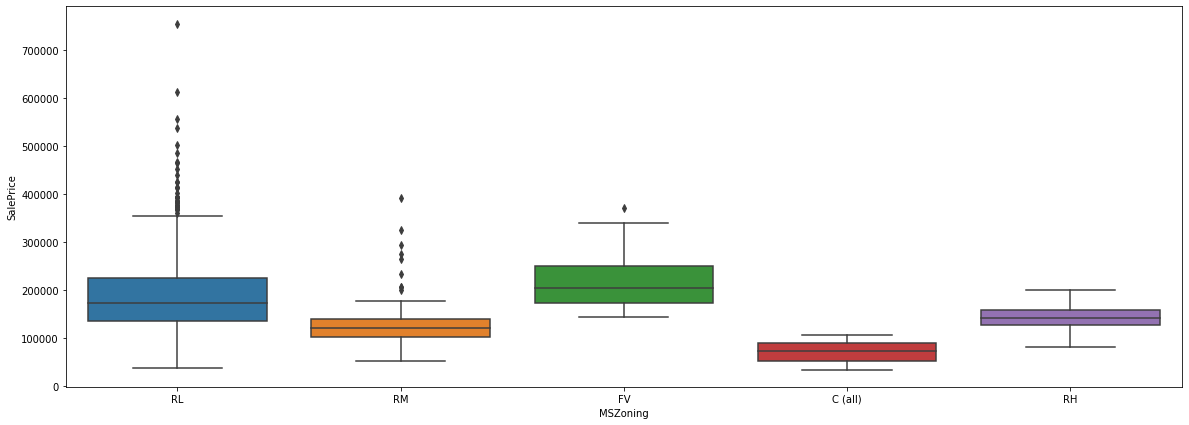

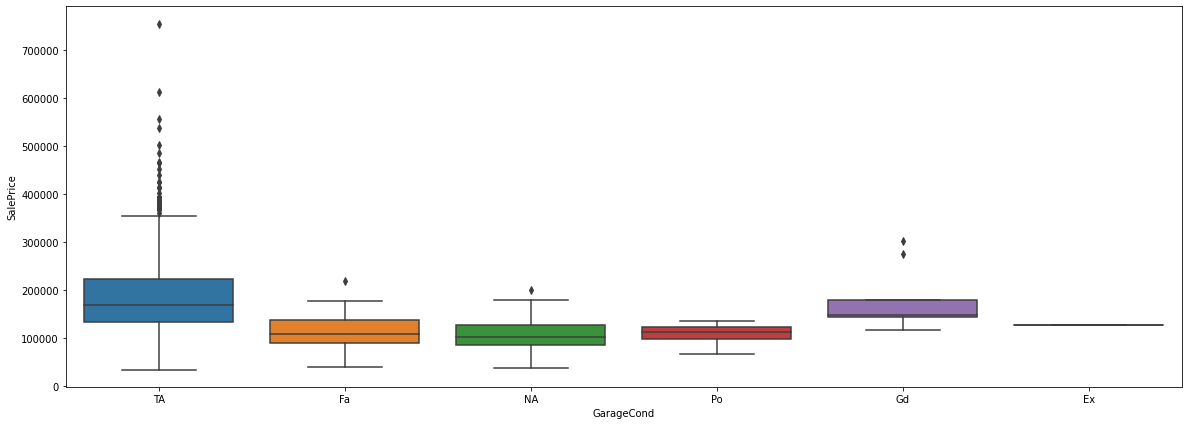

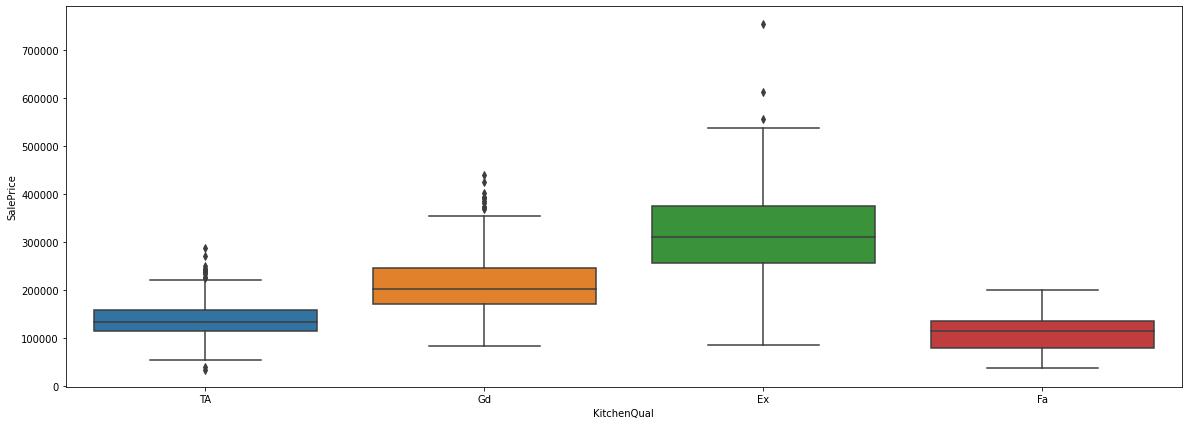

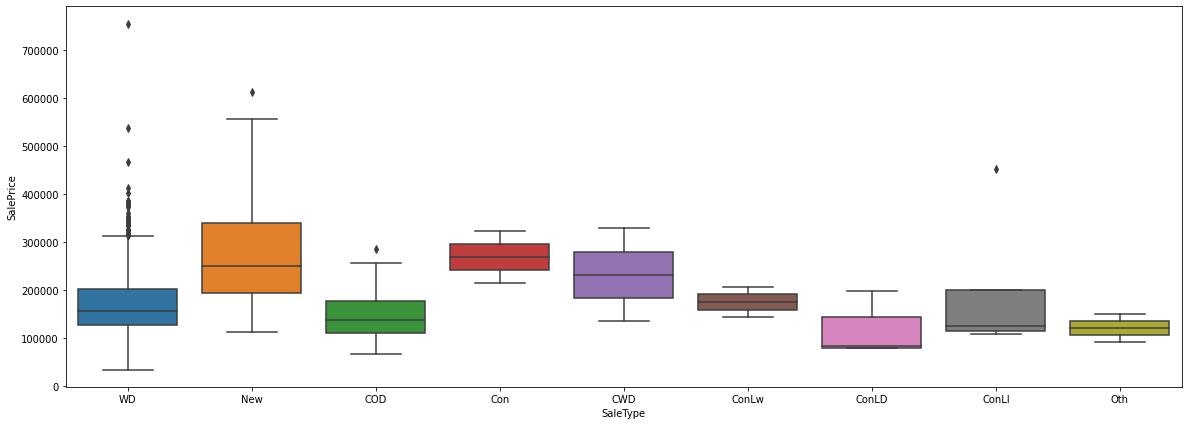

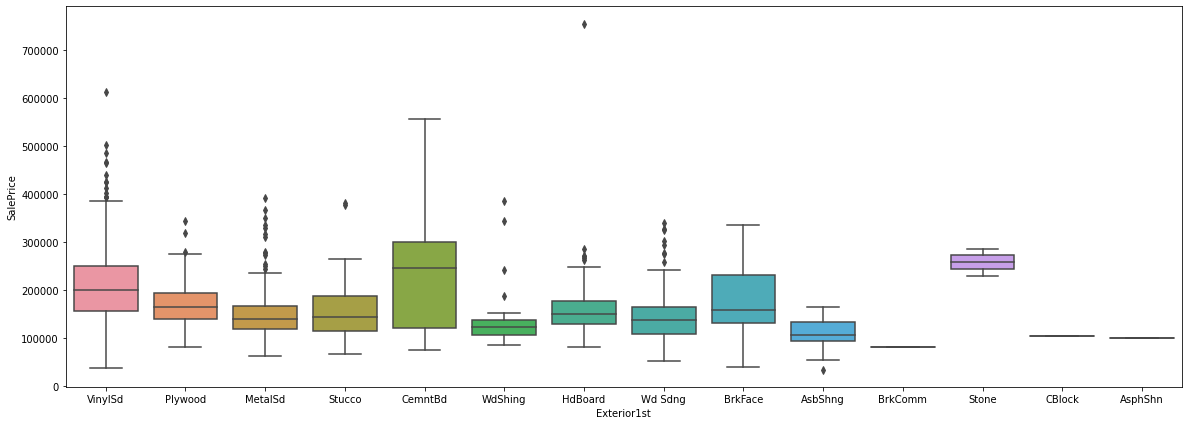

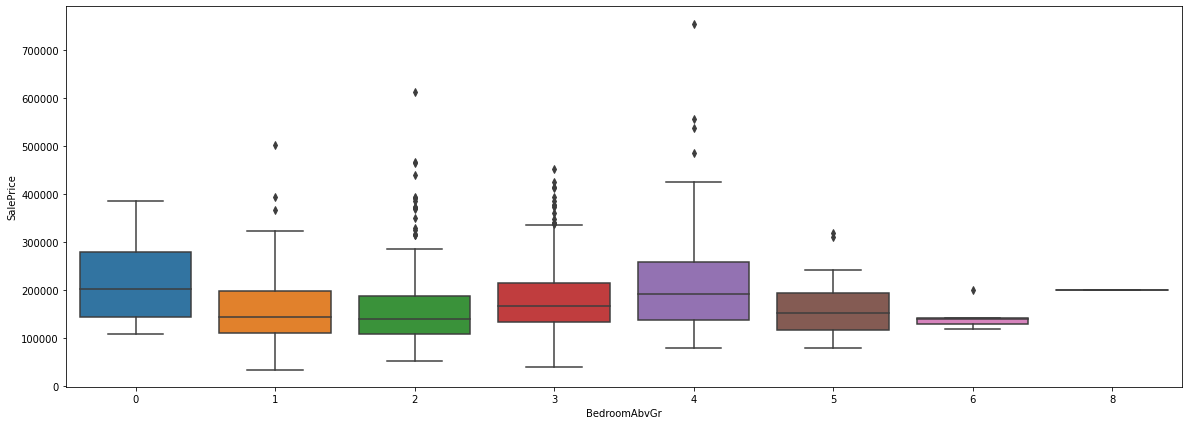

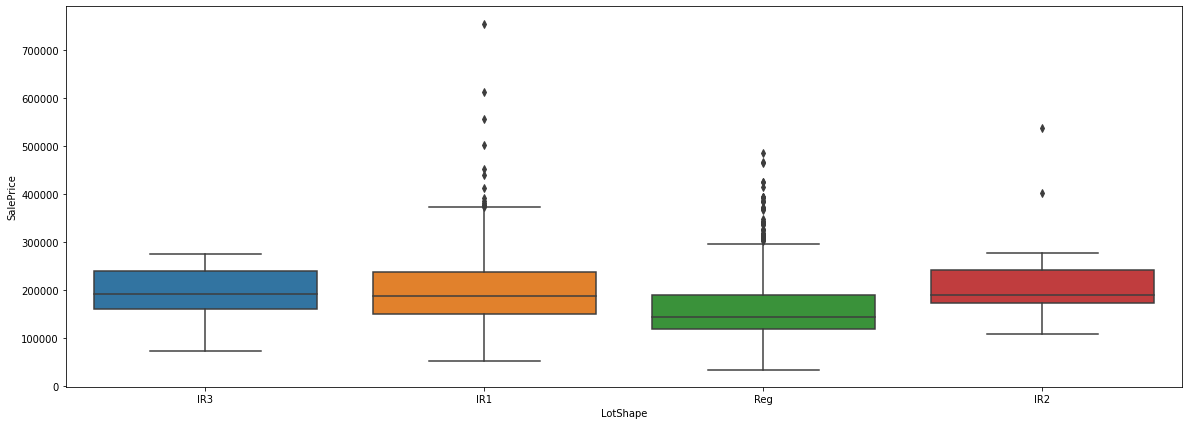

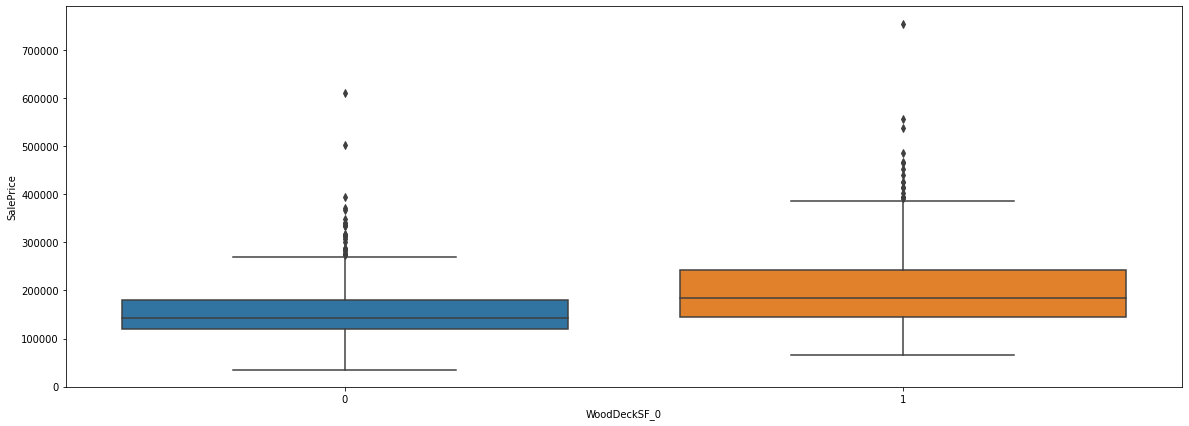

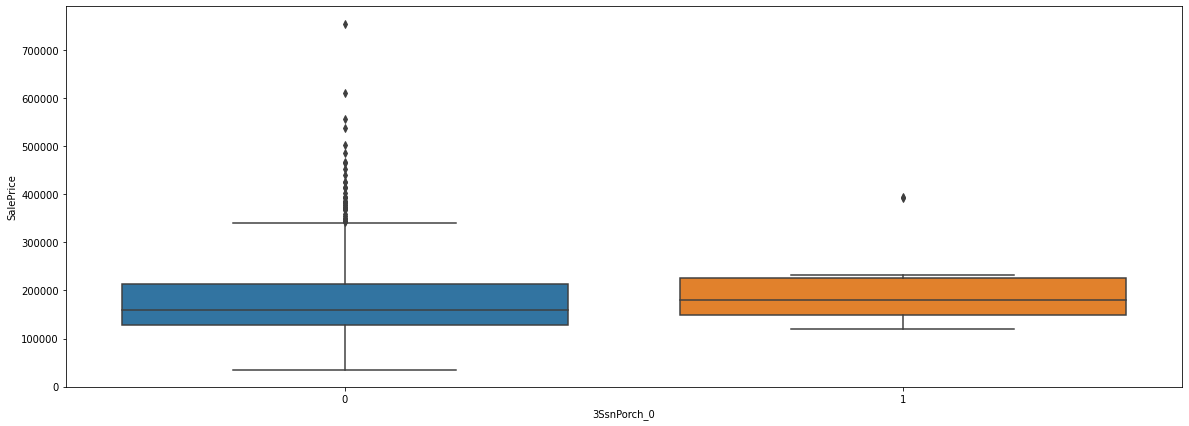

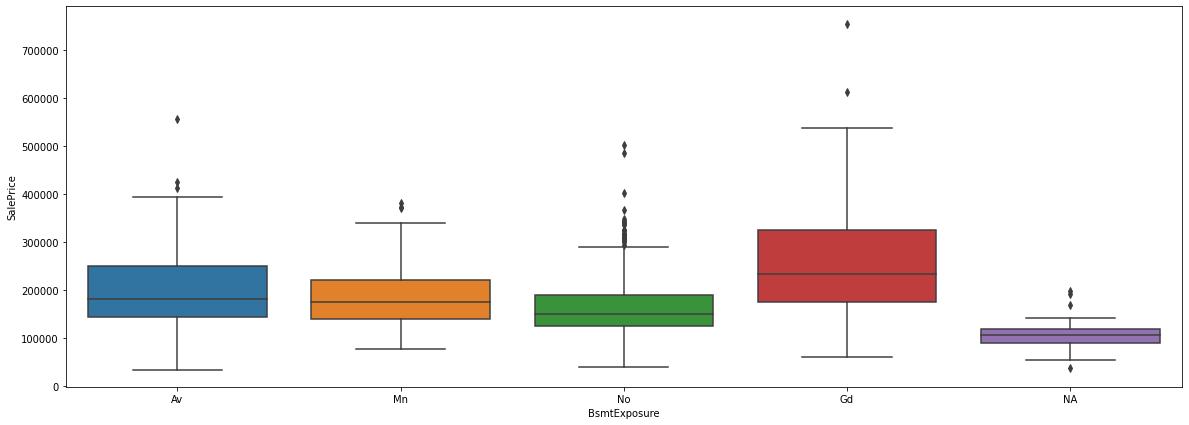

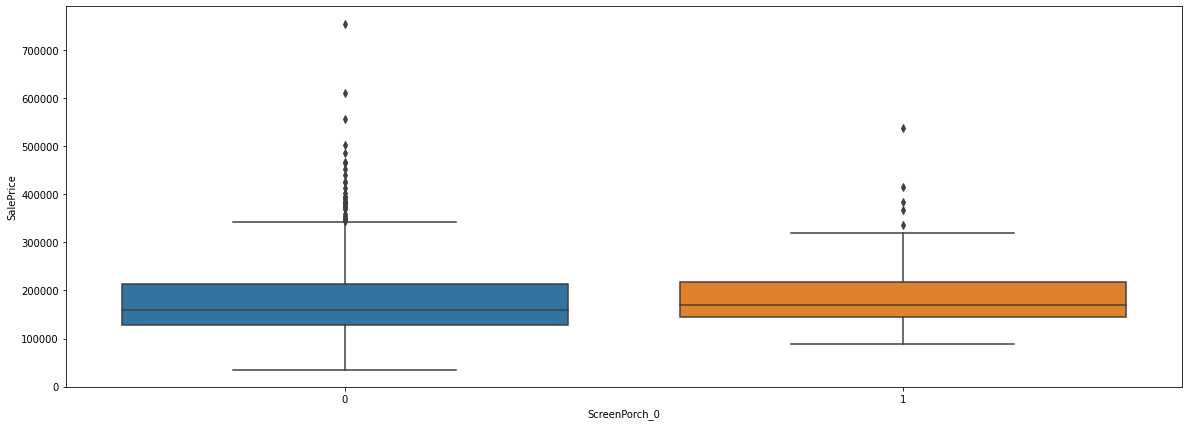

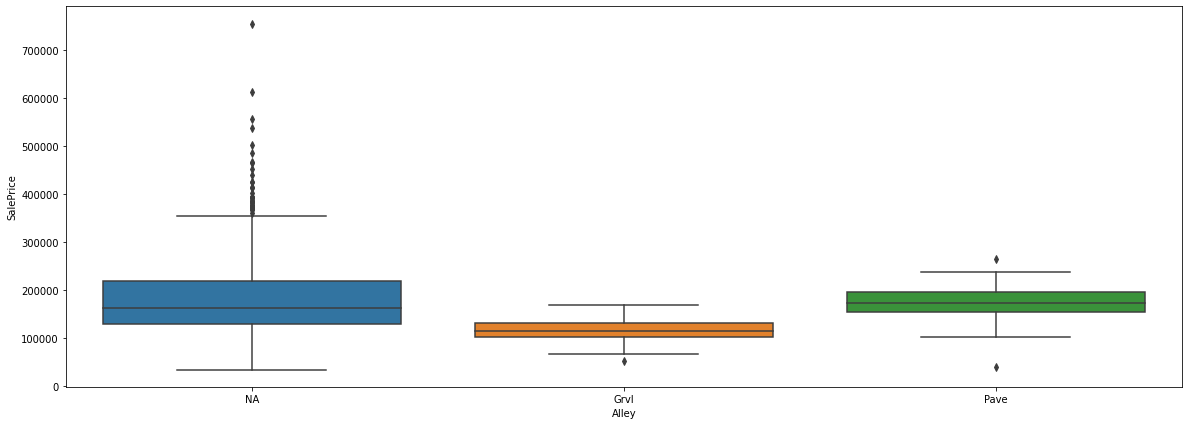

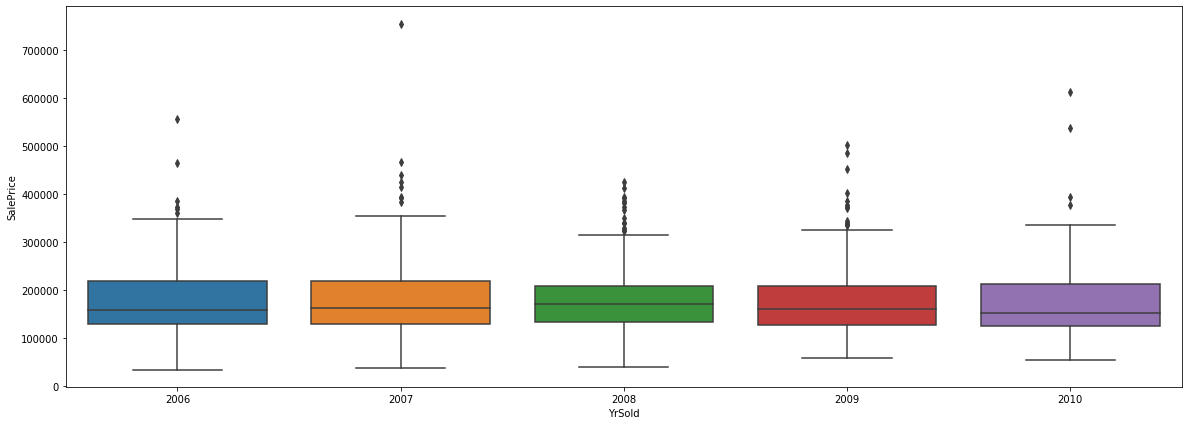

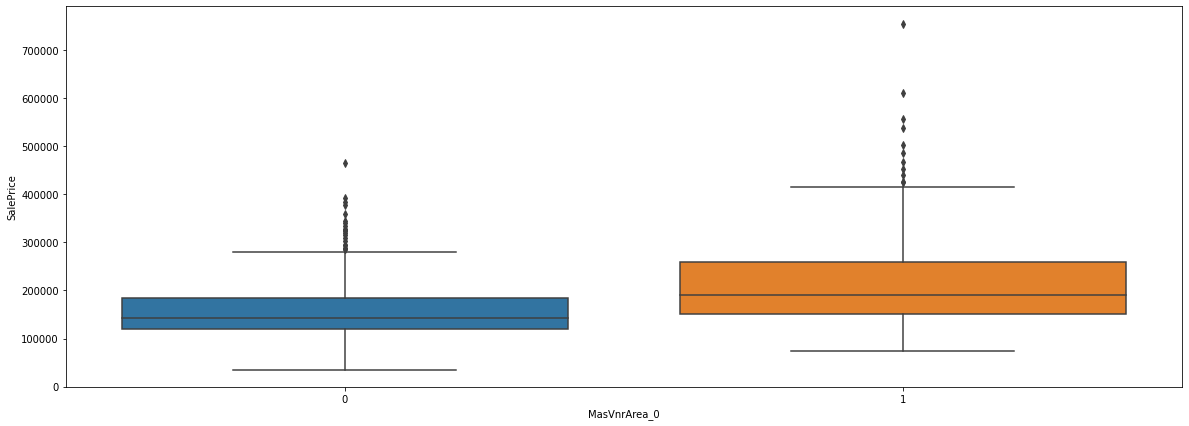

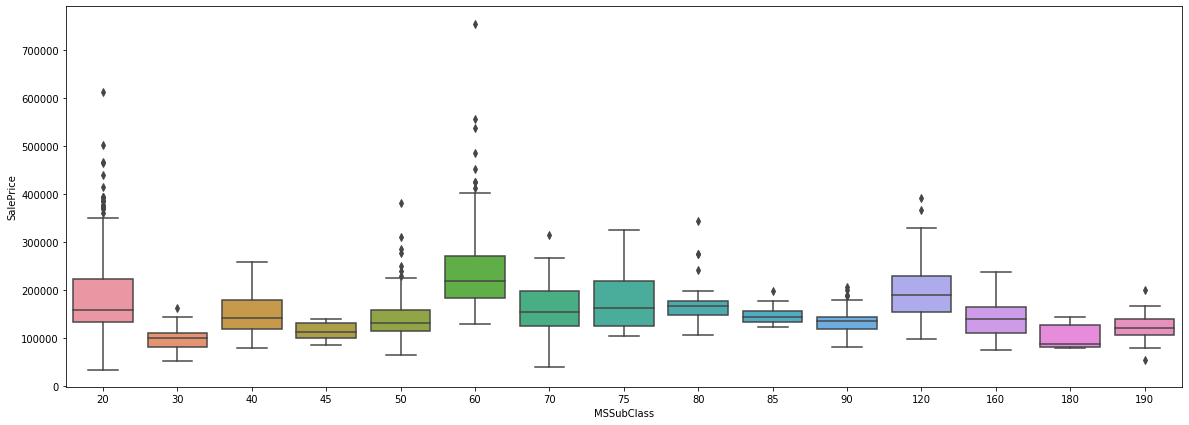

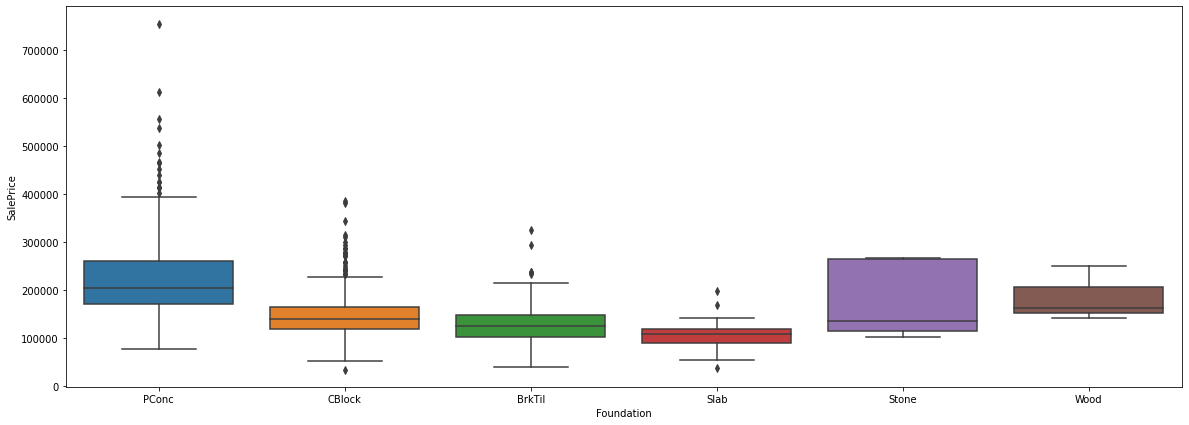

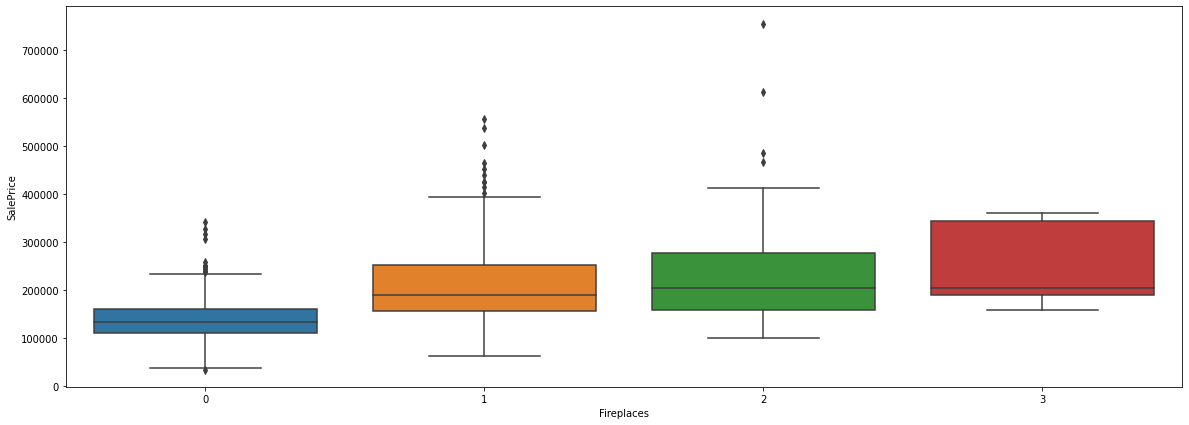

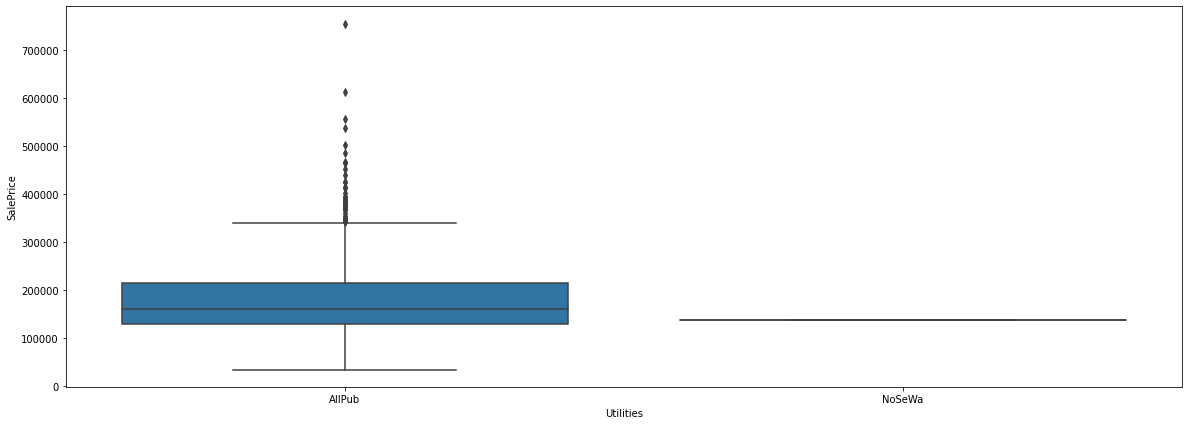

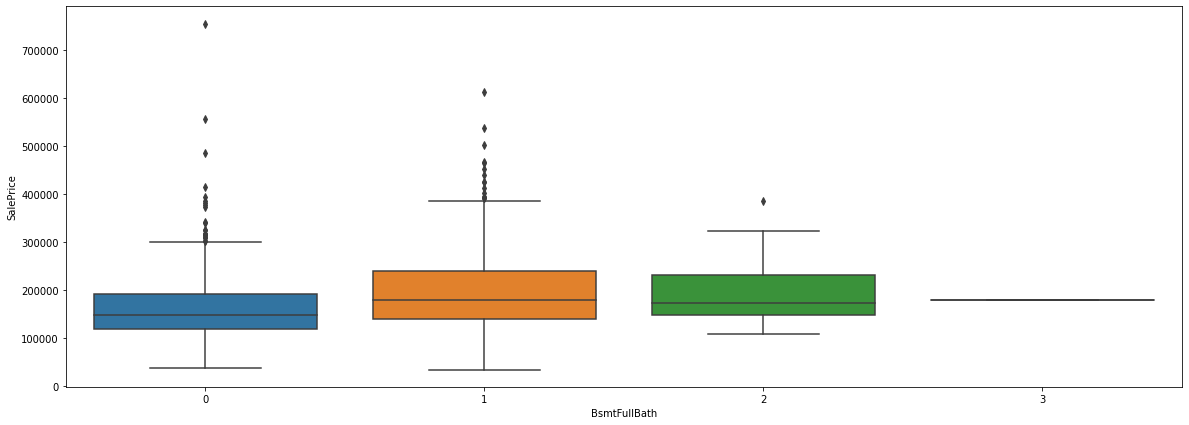

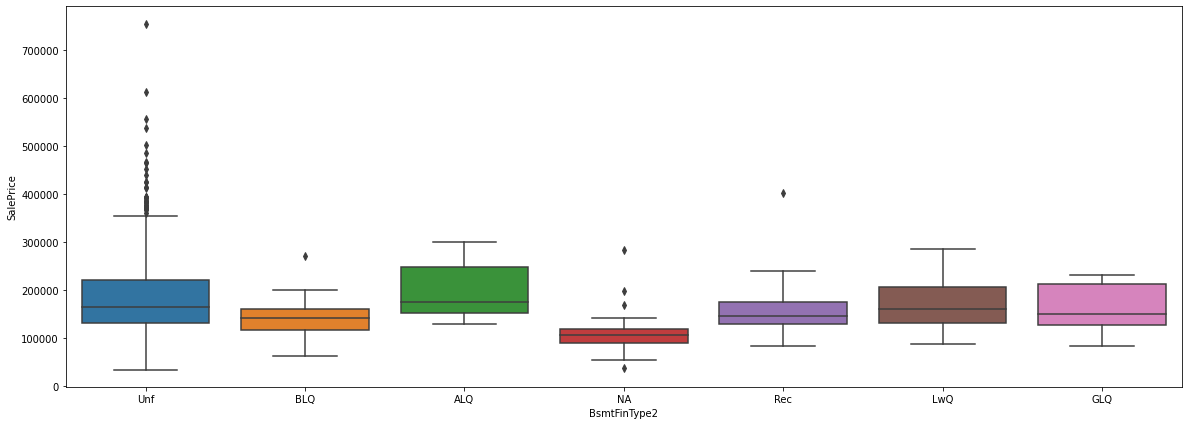

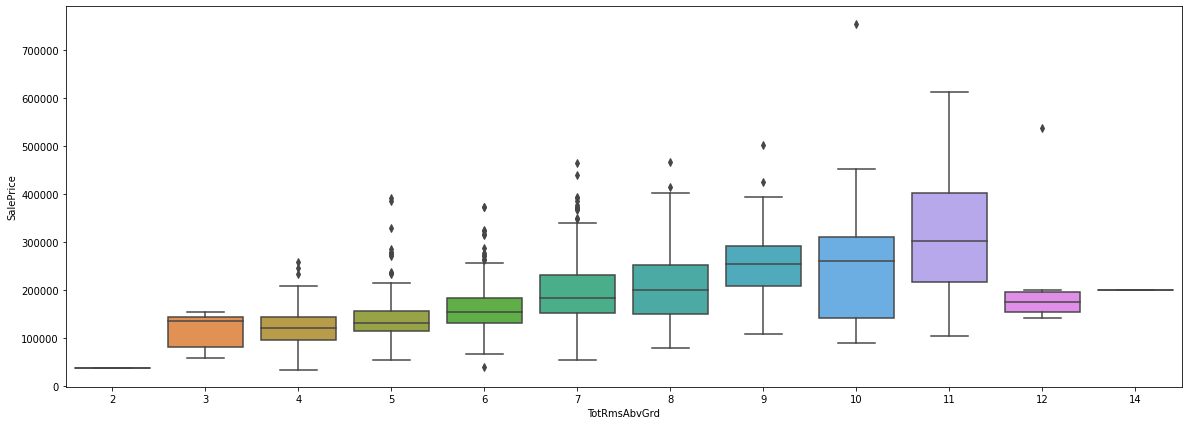

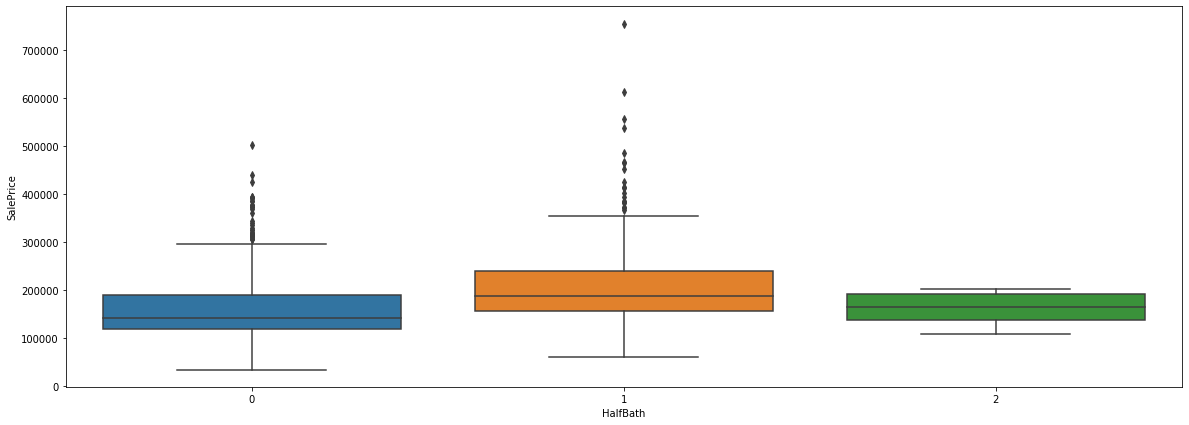

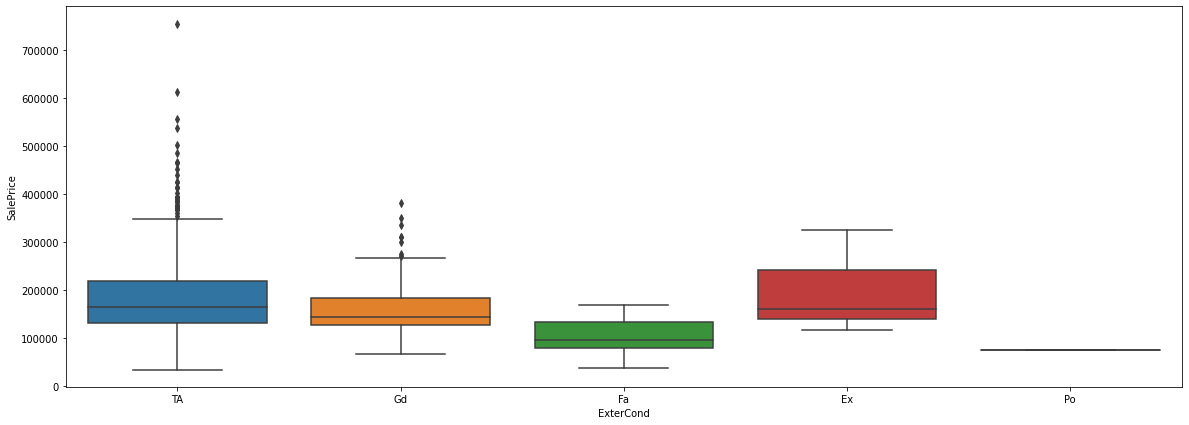

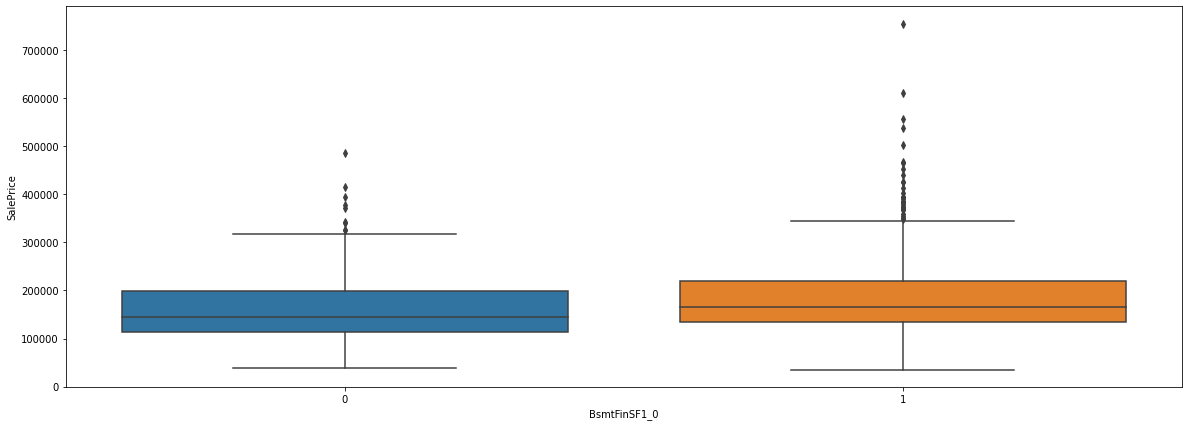

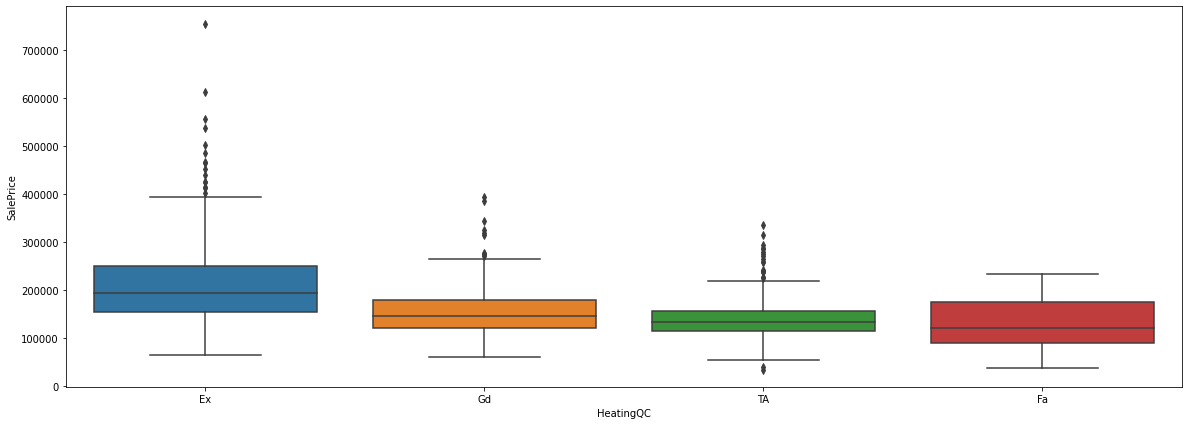

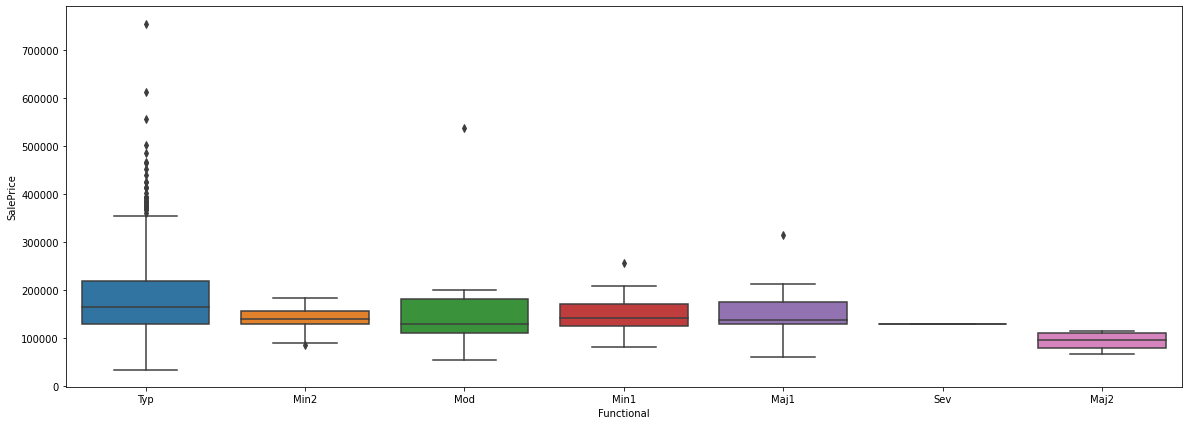

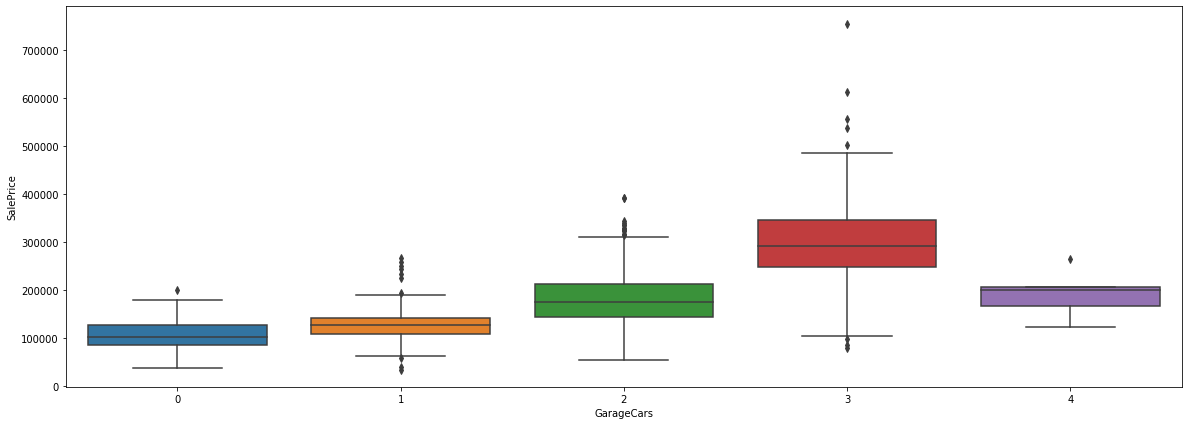

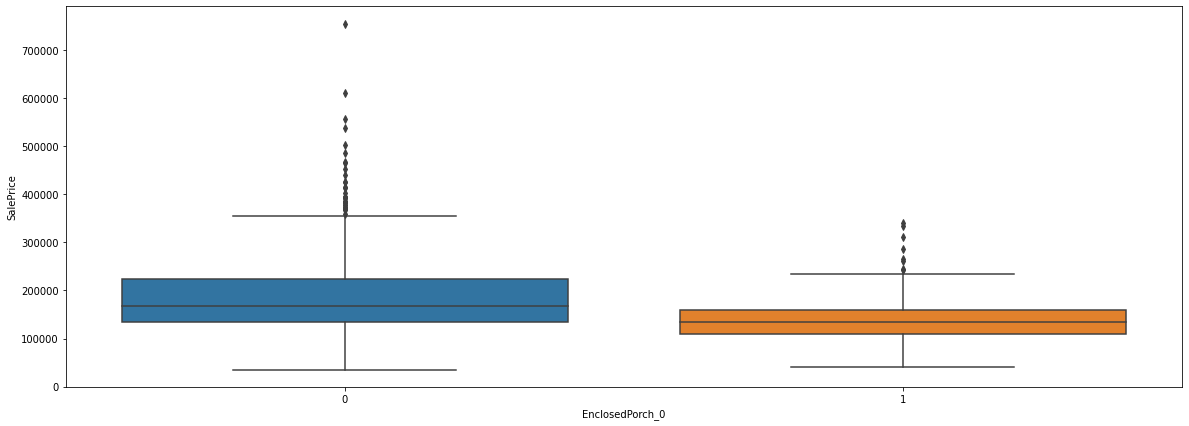

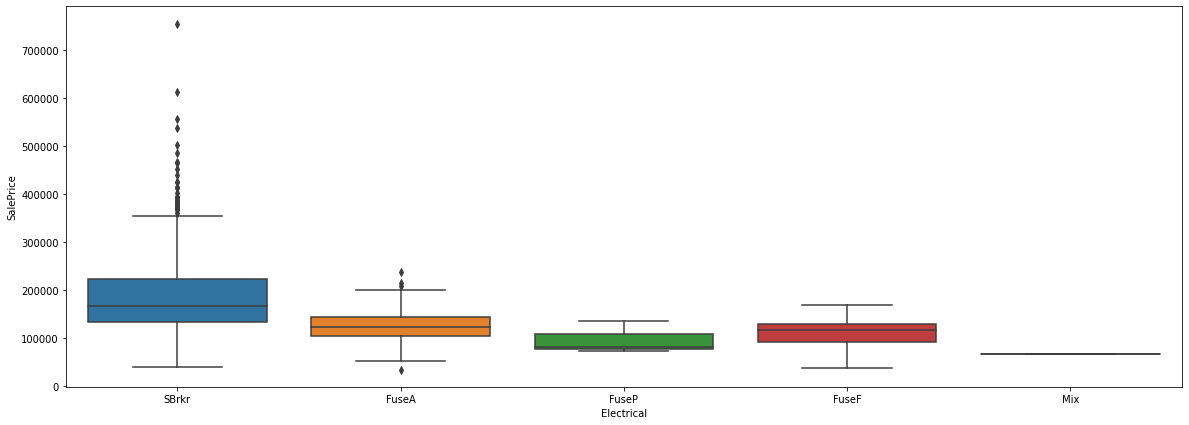

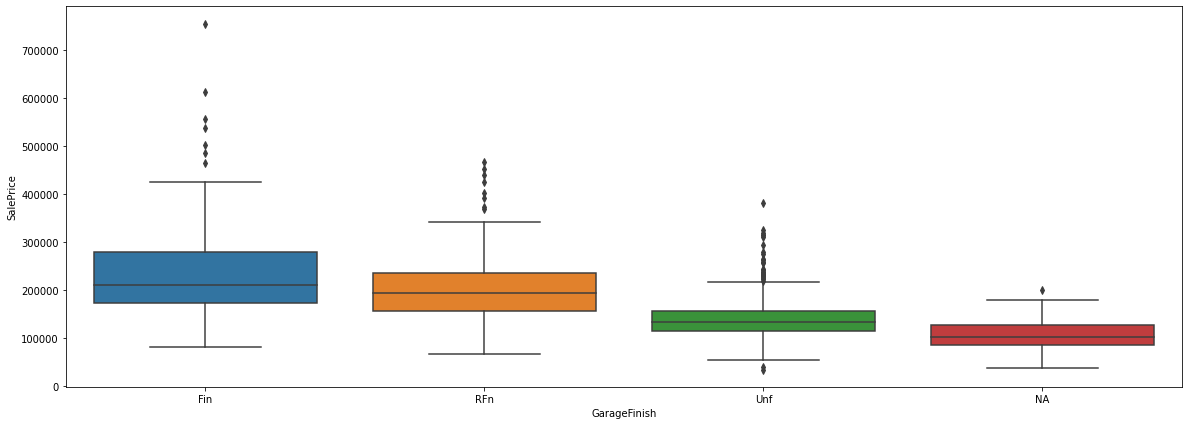

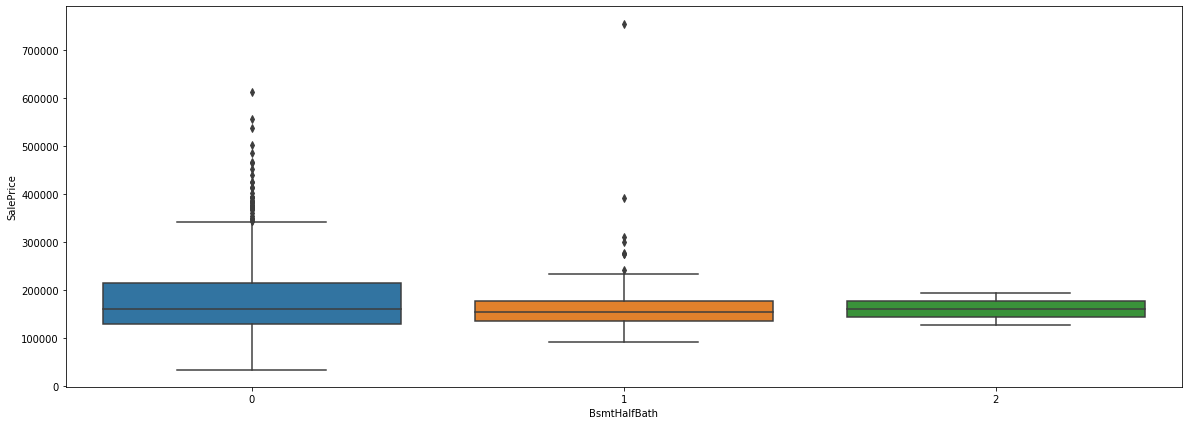

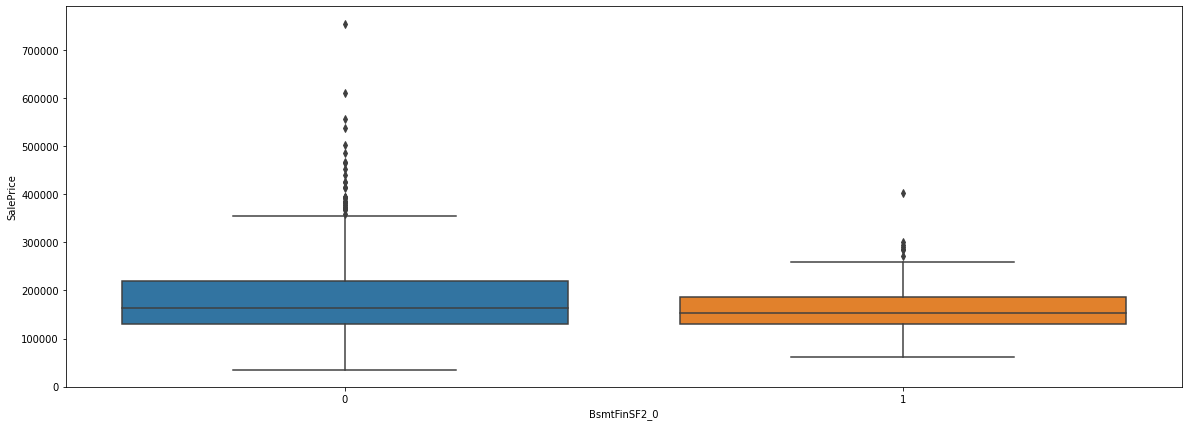

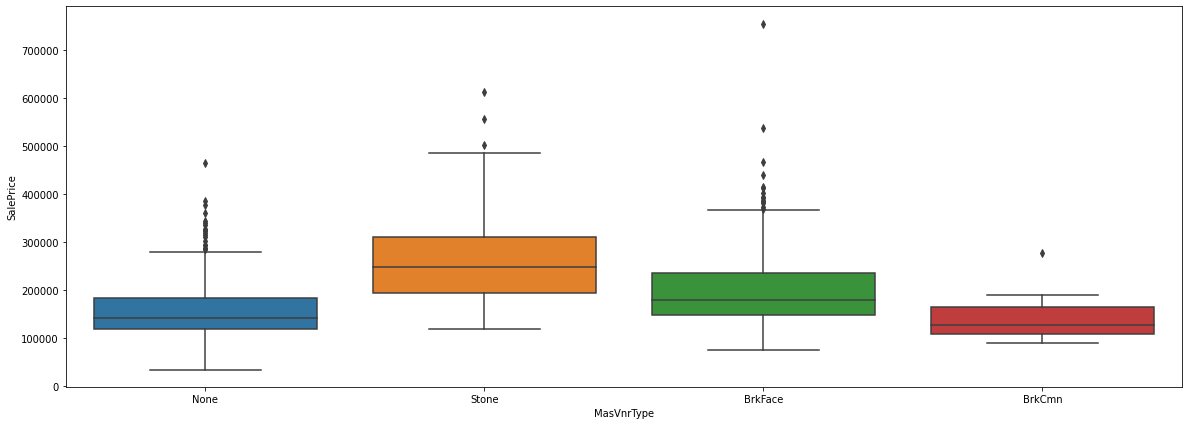

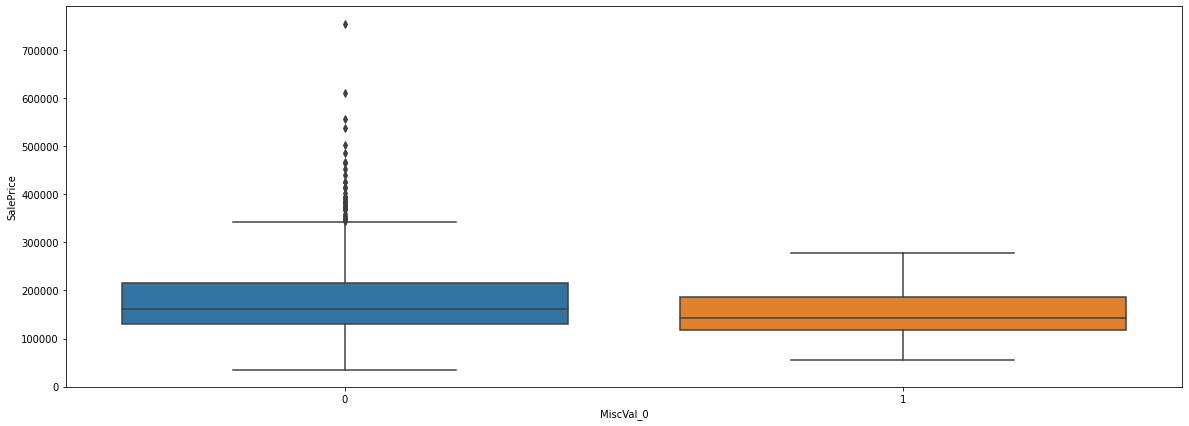

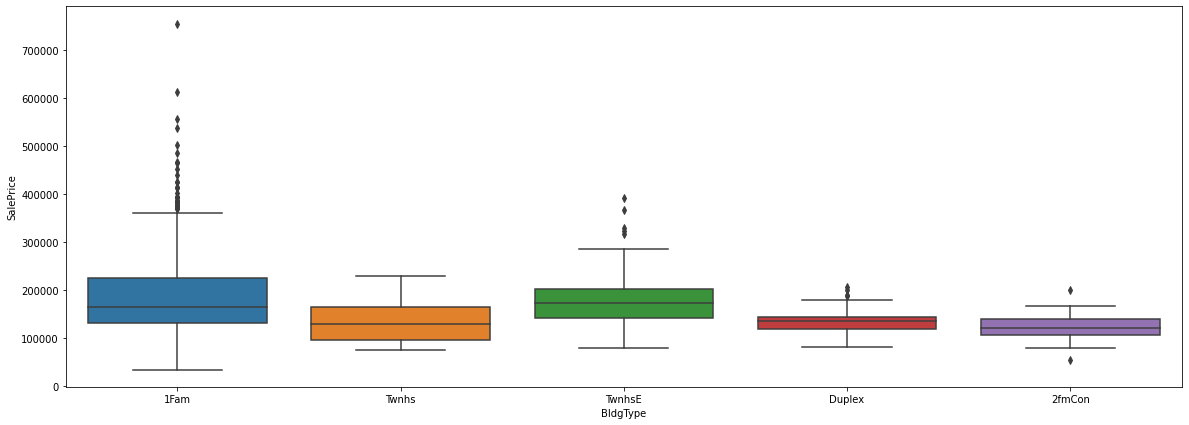

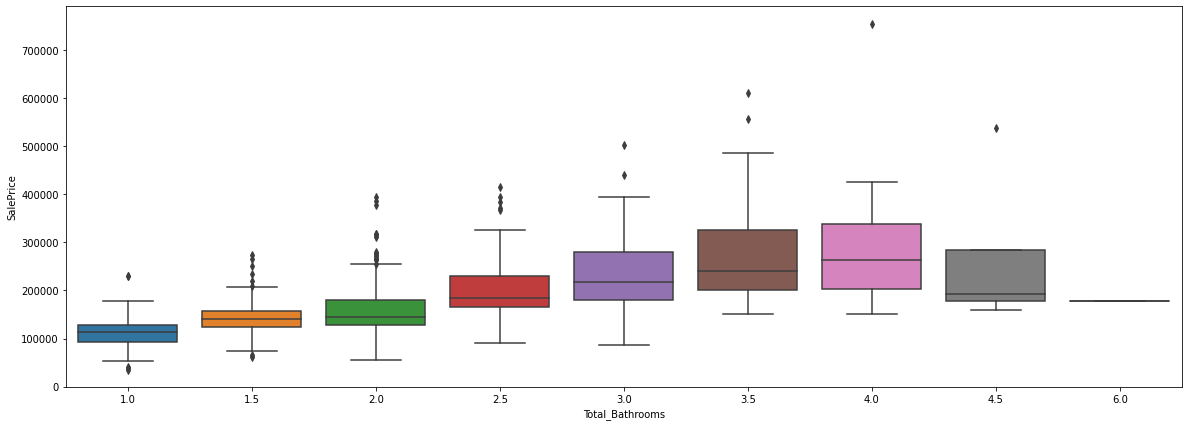

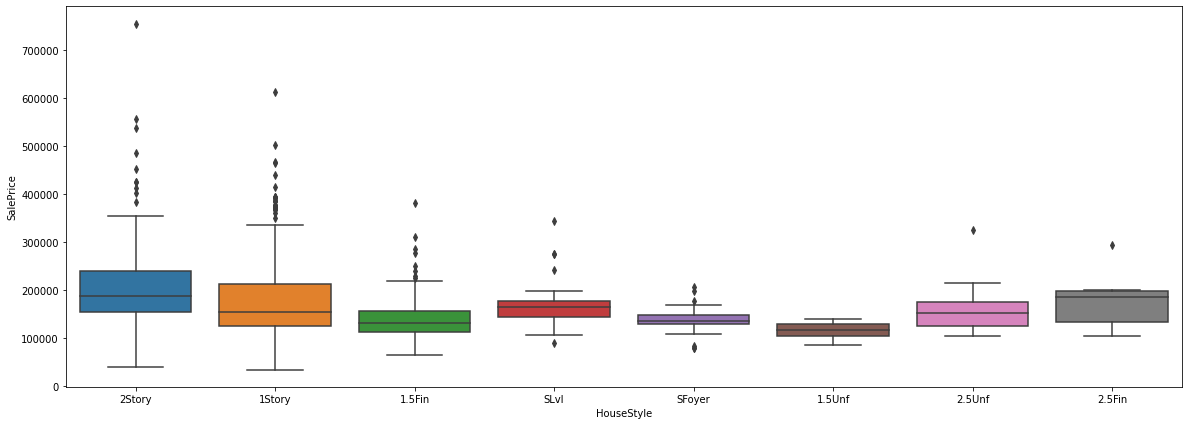

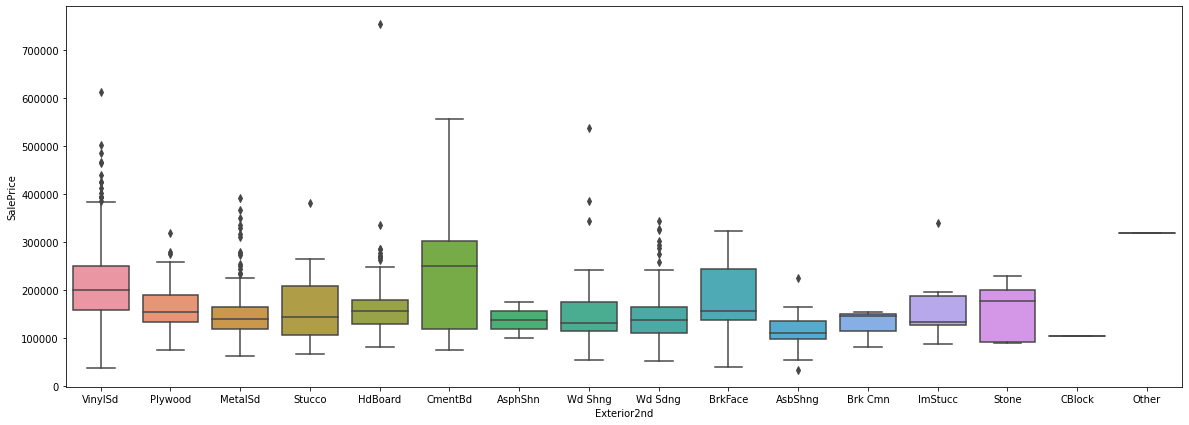

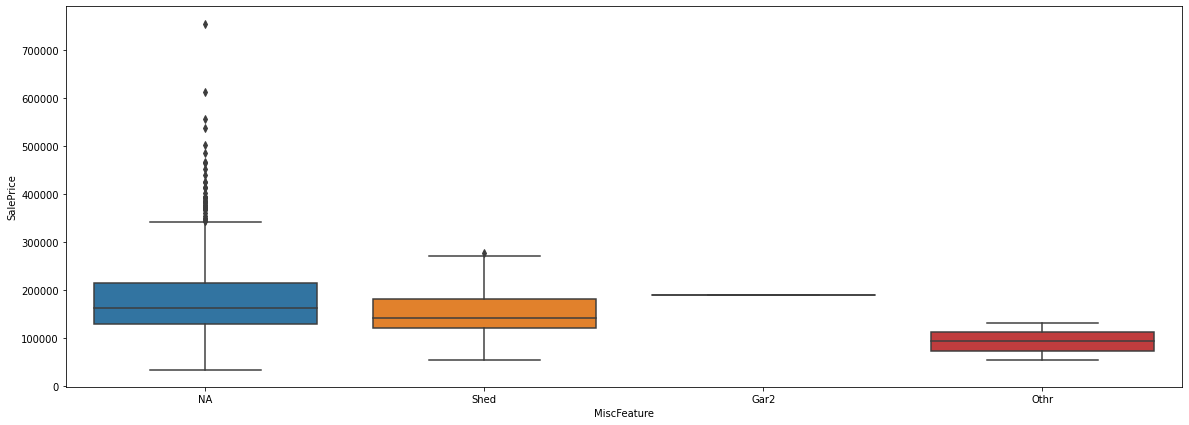

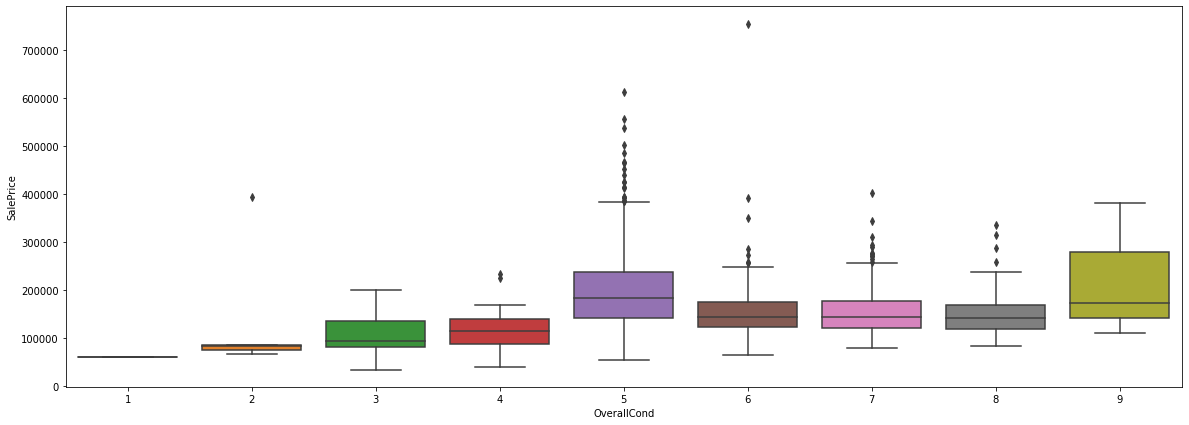

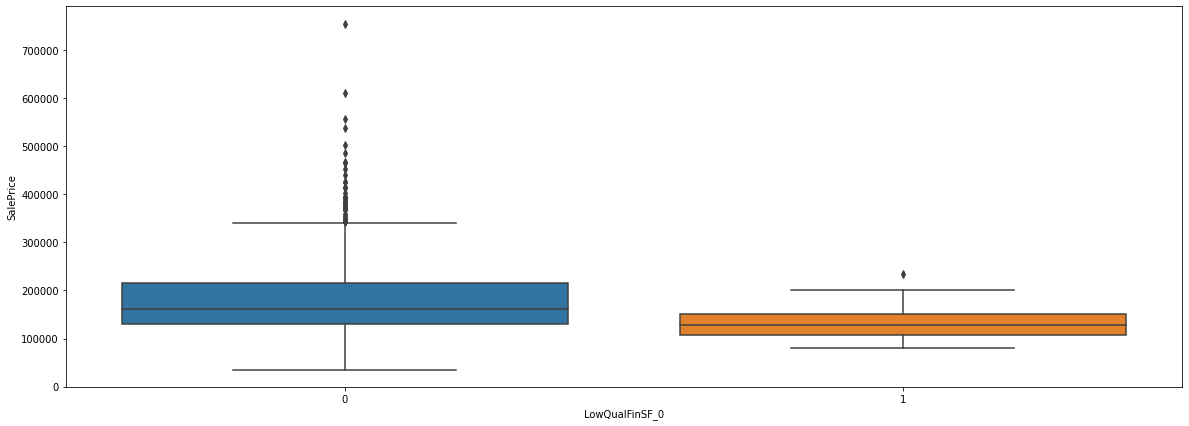

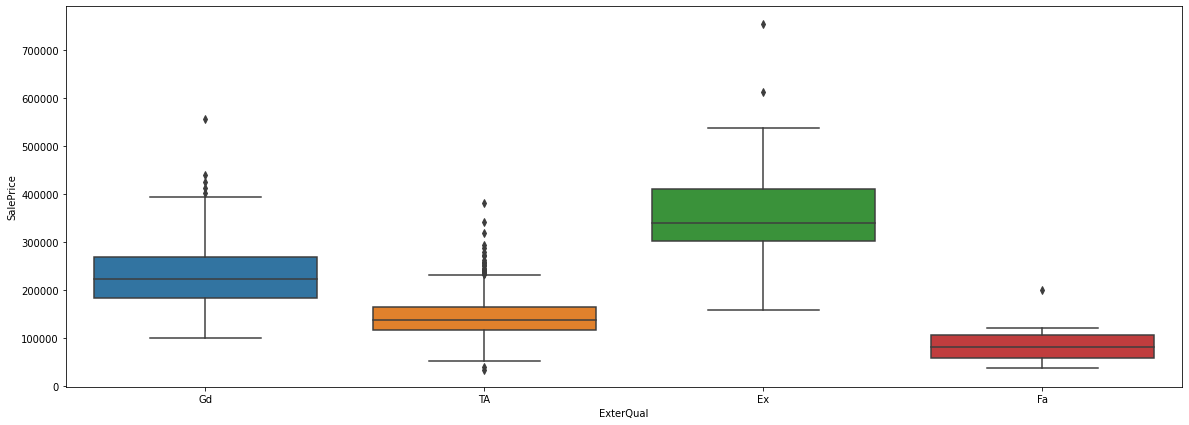

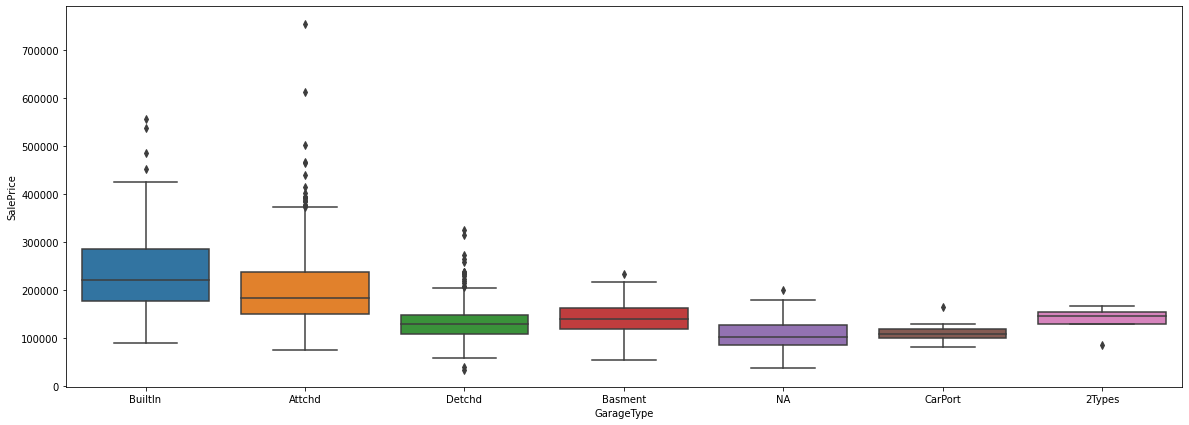

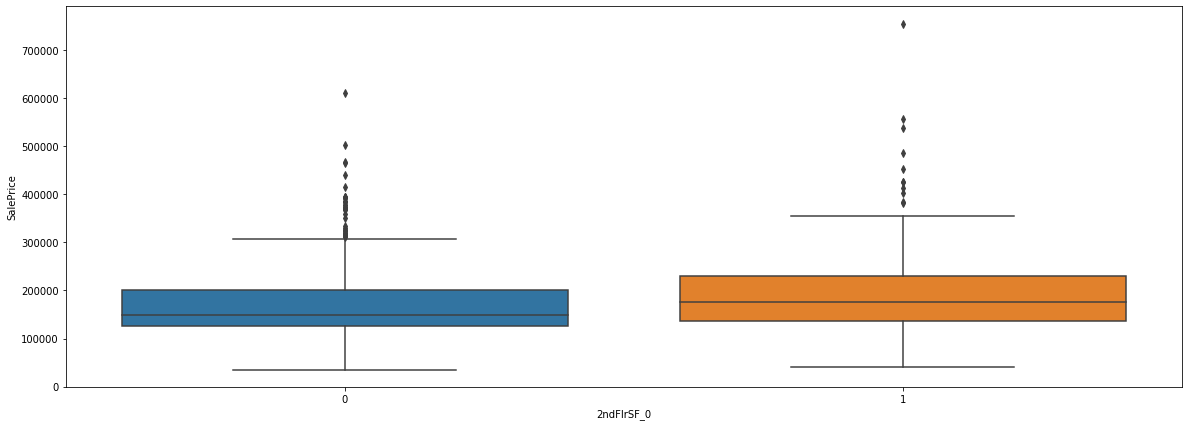

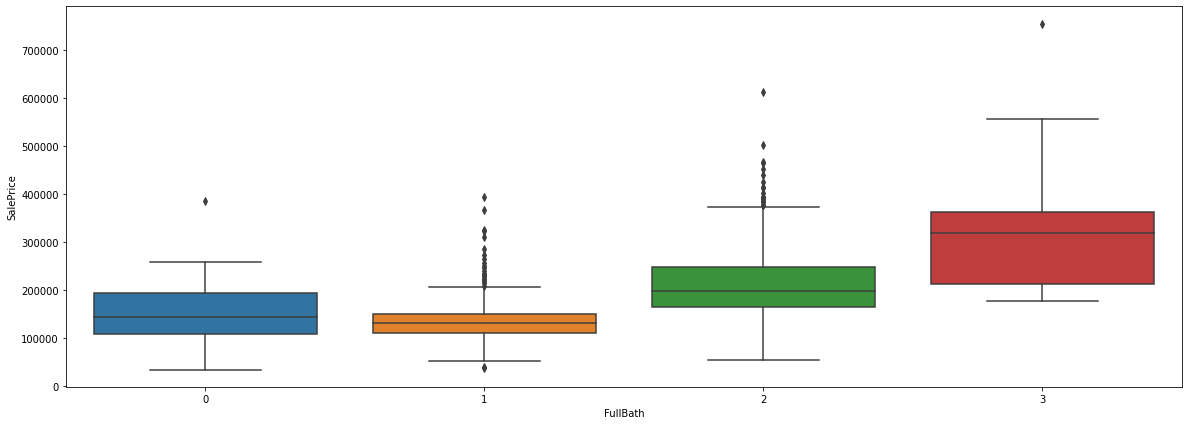

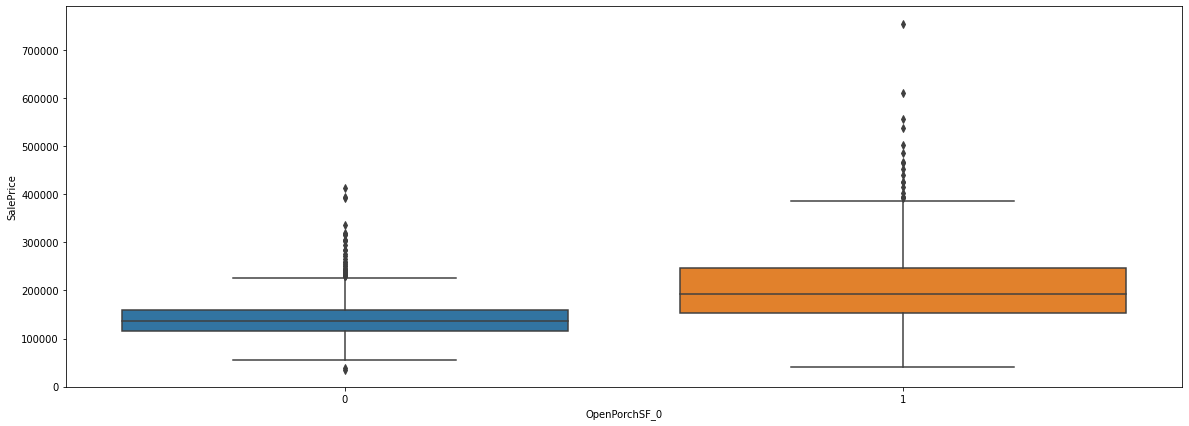

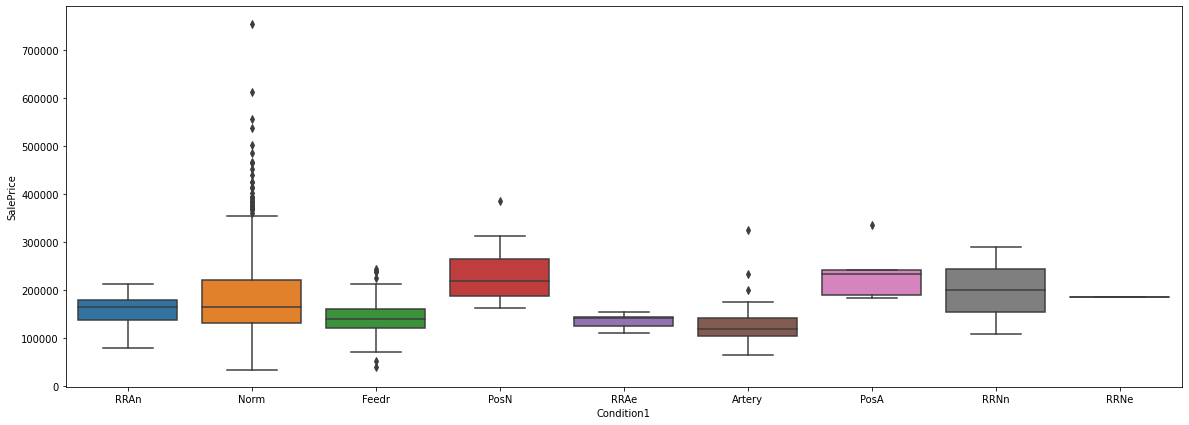

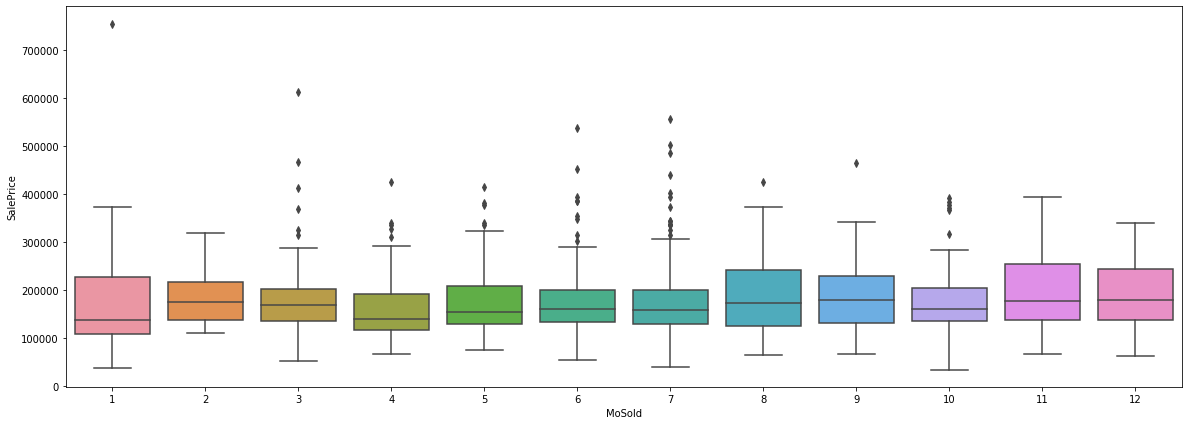

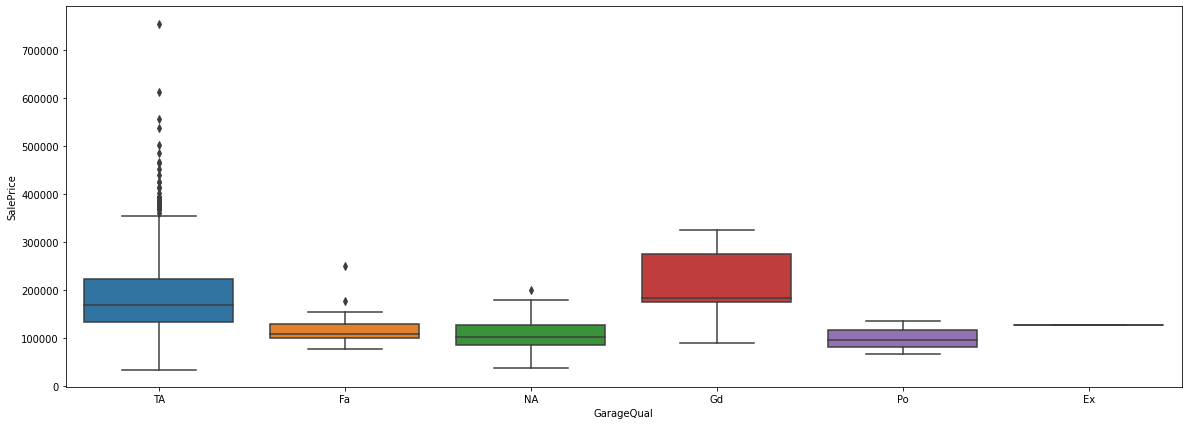

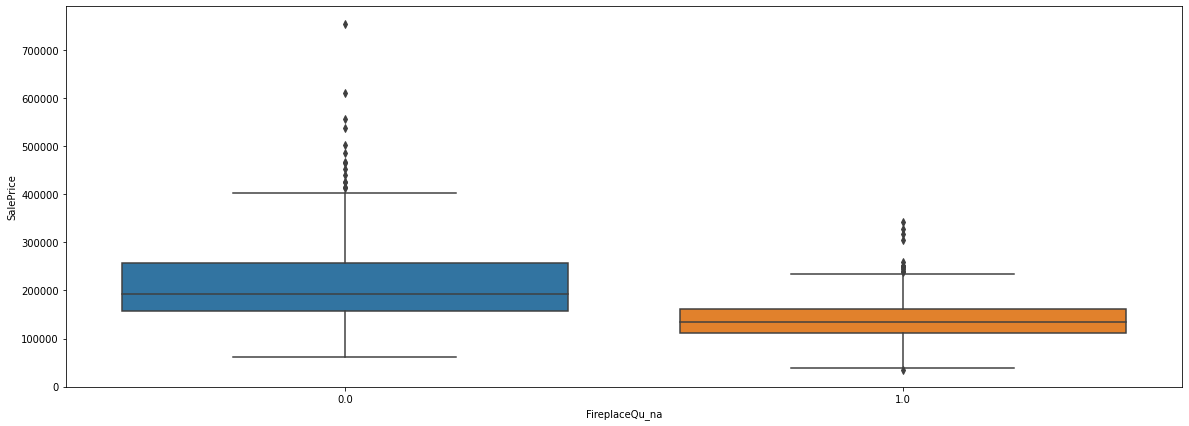

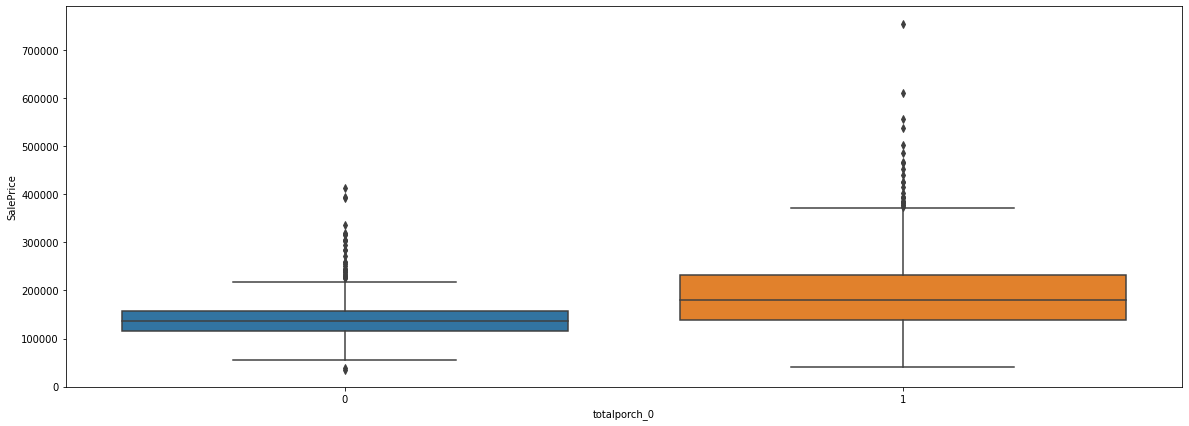

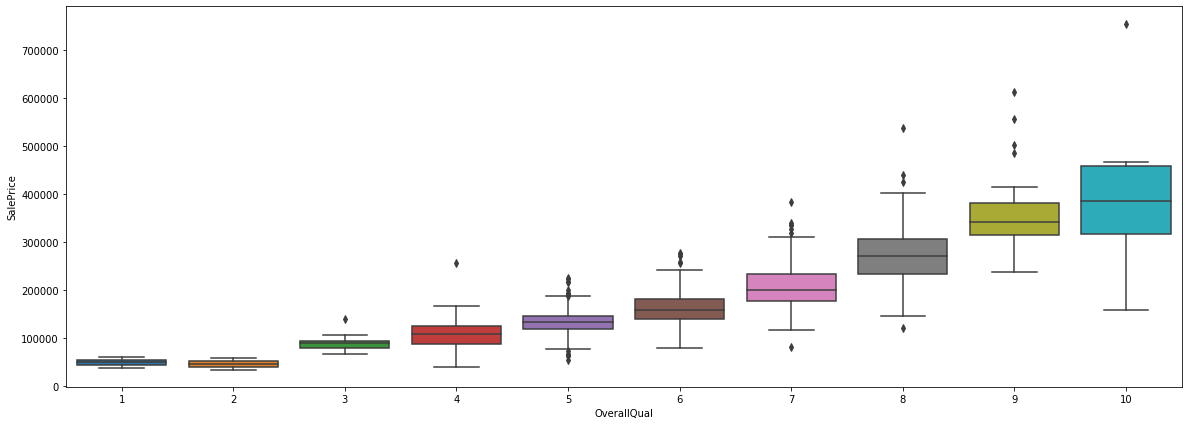

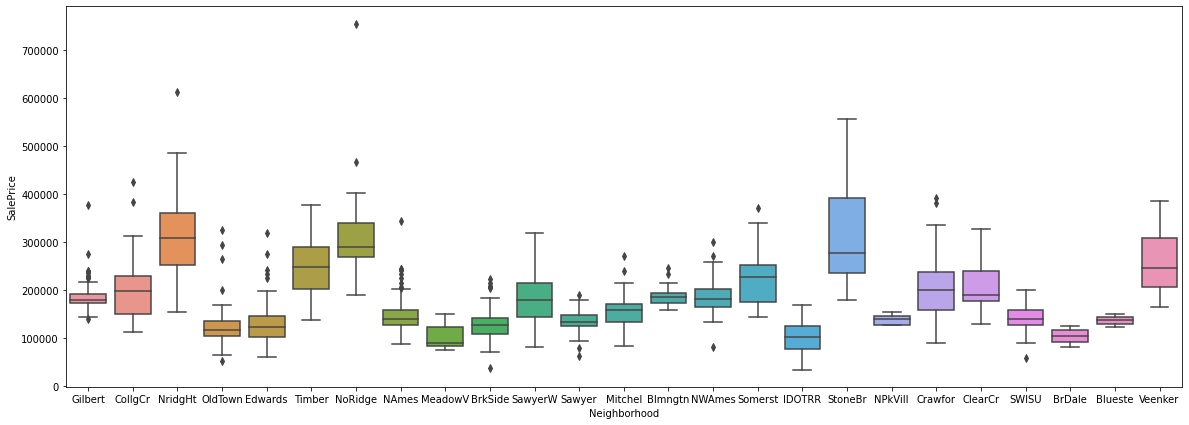

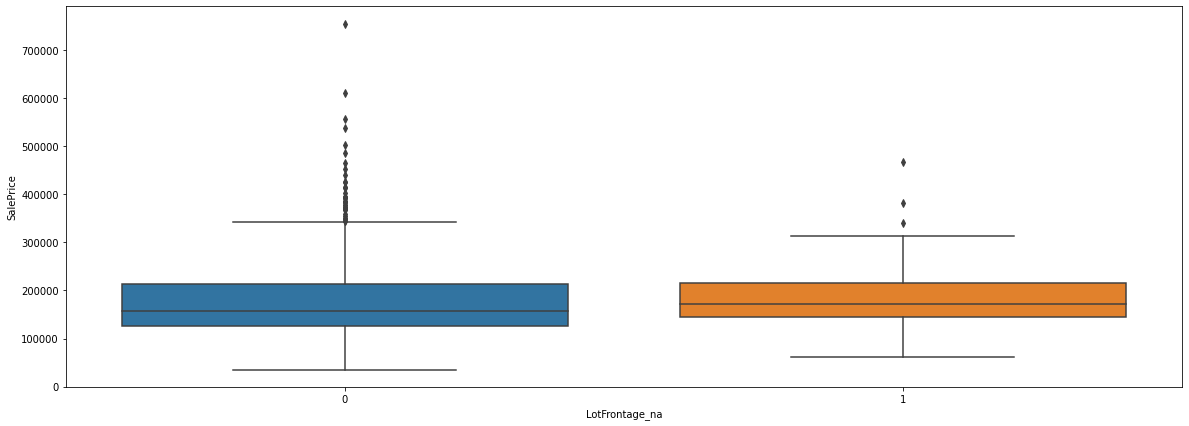

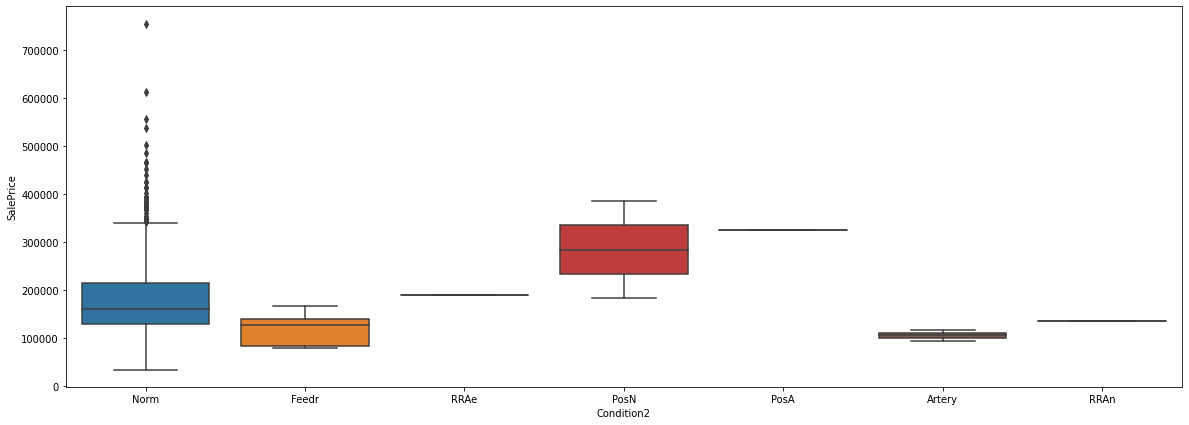

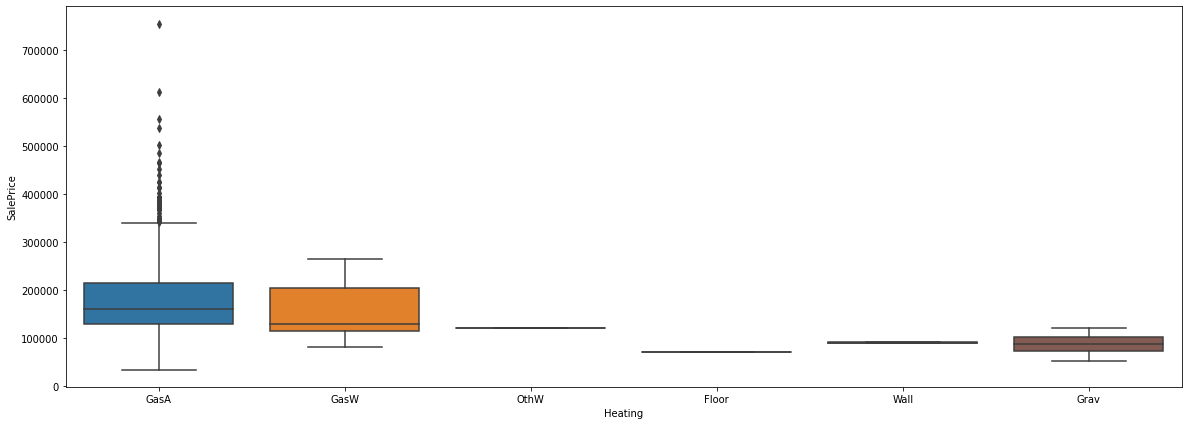

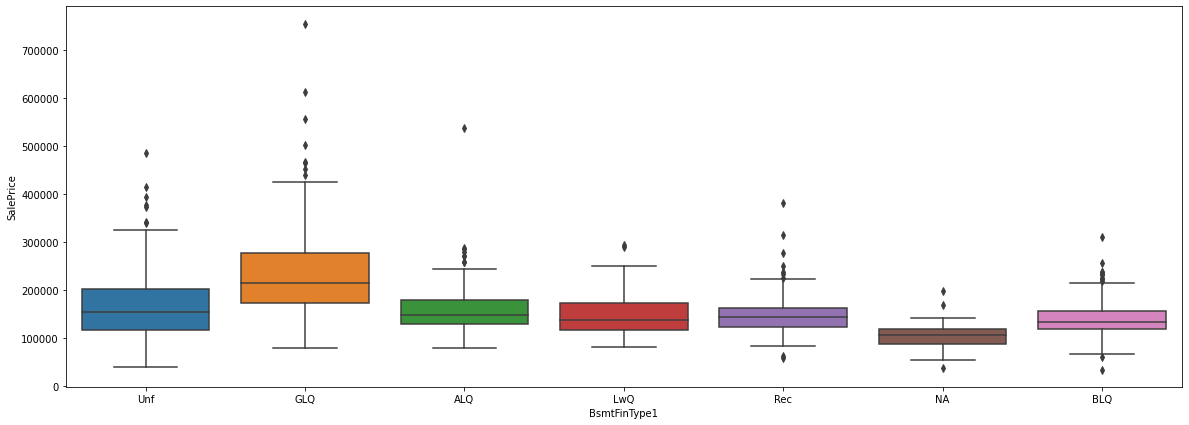

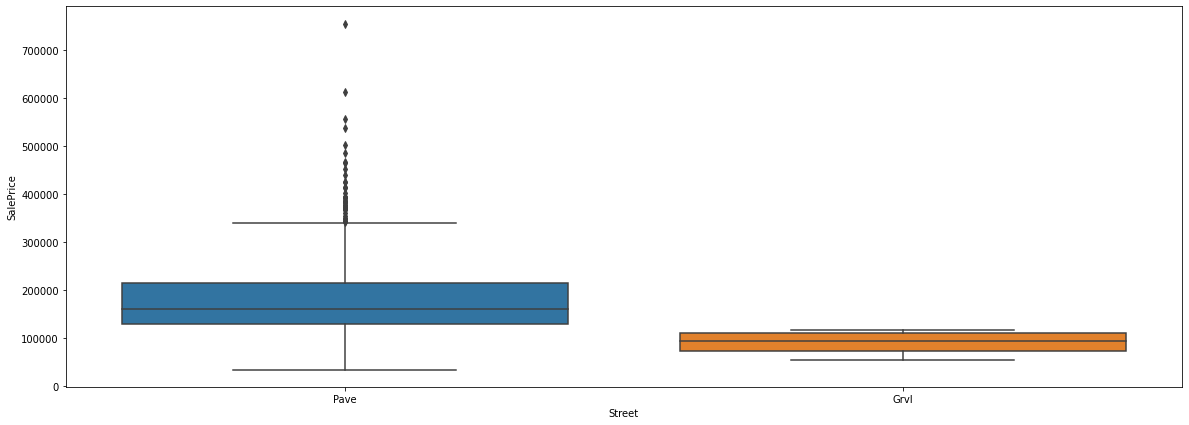

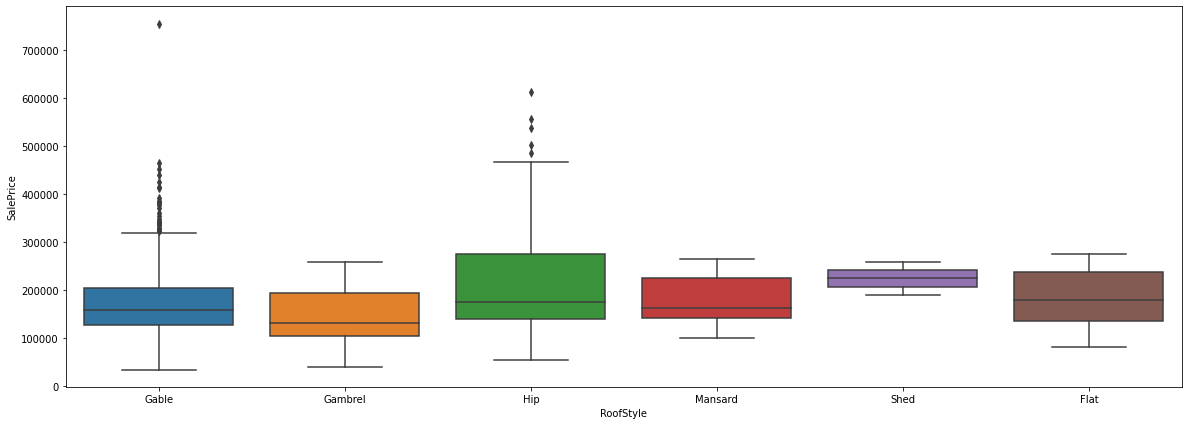

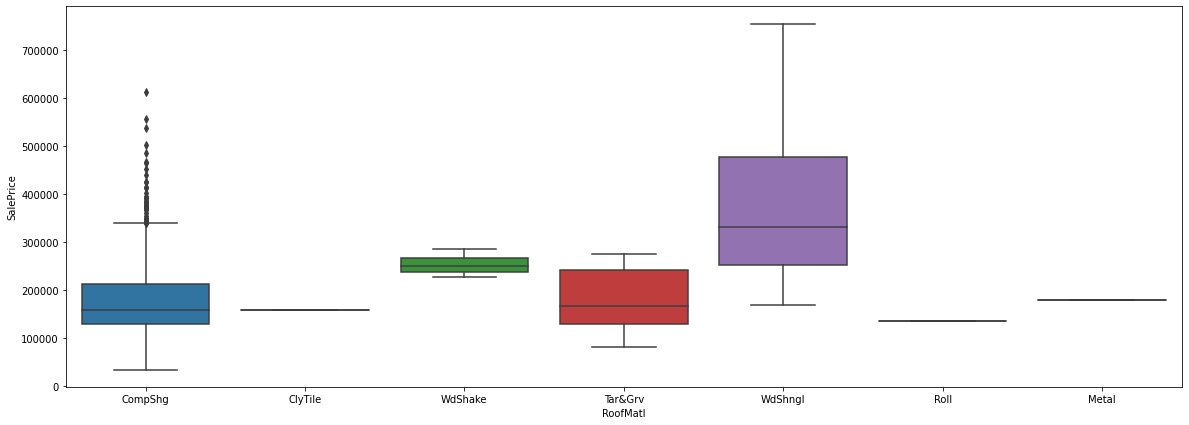

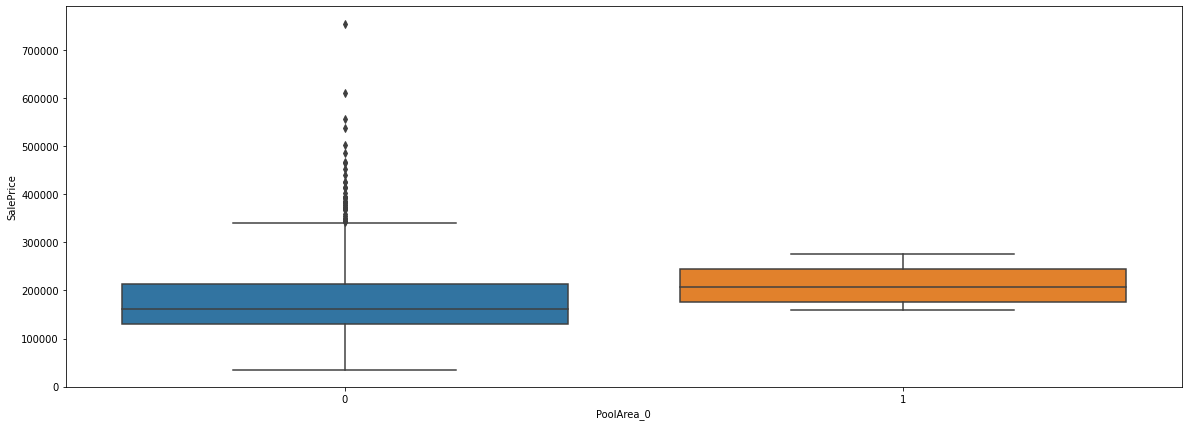

In [56]:
for idx, col in enumerate(catlist):
  plt.figure(figsize=(20,7))
  sns.boxplot(x = col, y = 'SalePrice', data = train)
  plt.show()

In [57]:
# 拿掉趨勢線與價格沒有太大關係的類別型變數
cat_drop_list = ['Utilities', 'BsmtFinSF1_0', 'YrSold']
train_test.drop(cat_drop_list, axis = 1, inplace = True)
catlist = [ele for ele in catlist if ele not in cat_drop_list]

In [58]:
# 處理TRAIN中沒出現的類別型變數
for col in catlist:
  if(len(train[col].unique()) < len(test[col].unique())):
    print(col)
    print(train[col].unique())
    print(test[col].unique())

HeatingQC
['Ex' 'Gd' 'TA' 'Fa']
['Ex' 'Gd' 'TA' 'Fa' 'Po']


In [59]:
train_test['HeatingQC'].replace('Po', train_test['HeatingQC'].mode()[0], inplace=True)

In [60]:
train_test_int = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(train_test[intlist]))
train_test_int.columns = train_test[intlist].columns
train_test_cat = train_test[catlist]
train_test_cat.reset_index(drop=True, inplace=True)
train_test_dummy = pd.get_dummies(train_test_cat, columns=catlist)
train_test_base = pd.concat([train_test_dummy, train_test_int],axis=1)
data_base = train_test_base[:1095]
test_base = train_test_base[1095:]

In [61]:
outliers = IsolationForest(contamination = 0.05, random_state = 23).fit_predict(data_base)
data_base['outlier'] = outliers
data_base['y'] = y_ori
data_base_isofo = data_base[data_base['outlier'] == 1]
y_isofo = data_base_isofo['y']
data_base_isofo.drop(['outlier', 'y'], axis=1, inplace=True)
data_base.drop(['outlier', 'y'], axis=1, inplace=True)
data_base_isofo.shape

(1040, 406)

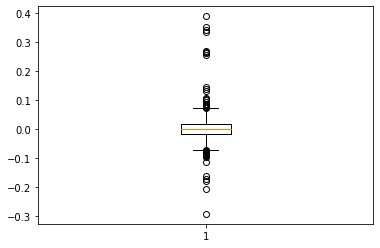

In [62]:
lgbm = lgb.LGBMRegressor()
lgbm.fit(data_base, y_ori)
ypred = lgbm.predict(data_base)
residual = ypred - y_ori
fig = plt.boxplot(residual)
data_base['res'] = residual
data_base['y'] = y_ori

In [63]:
data_base_res = data_base[(data_base['res'] < 0.08) & (data_base['res'] > -0.08)]
y_res = data_base_res['y']
data_base.drop(['res', 'y'], axis=1, inplace=True)
data_base_res.drop(['res', 'y'], axis=1, inplace=True)
print(data_base_res.shape)

(1076, 406)


In [75]:
kf=KFold(n_splits=5, random_state=23, shuffle=True)

lgbm = lgb.LGBMRegressor()
scores = cross_val_score(lgbm, data_base, y_ori, scoring = 'neg_mean_squared_error', cv = kf)
print('original: ', -round(scores.mean(), 4))

lgbm = lgb.LGBMRegressor()
scores = cross_val_score(lgbm, data_base_isofo, y_isofo, scoring = 'neg_mean_squared_error', cv = kf)
print('isoforest: ', -round(scores.mean(), 4))

lgbm = lgb.LGBMRegressor()
scores = cross_val_score(lgbm, data_base_res, y_res, scoring = 'neg_mean_squared_error', cv = kf)
print('residual: ', -round(scores.mean(), 4))

original:  0.0214
isoforest:  0.0179
residual:  0.0139


In [76]:
x = data_base_res
y = y_res

In [86]:
# 特徵篩選
lgbm = lgb.LGBMRegressor()
lgbm.fit(x, y)
feature_importance = pd.DataFrame({'feature_name':data_base_res.columns, 'importance':lgbm.feature_importances_})
feature_importance.sort_values(by = 'importance', ascending = False, inplace = True)
triallist = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400]

for idx, num in enumerate(triallist):
  x_final_select = x[feature_importance.iloc[:num, 0]]
  x_test_select = test_base[feature_importance.iloc[:num, 0]]
  lgbm = lgb.LGBMRegressor() 
  scores = cross_val_score(lgbm, x_final_select, y, scoring = 'neg_mean_squared_error', cv = kf)
  score = -round(scores.mean(), 5)
  if(idx == 0):
    final_score = score
    final_num = num
  else:
    if(score < final_score):
      final_score = score
      final_num = num
print(final_num, final_score)

10 0.02077
20 0.01933
30 0.01555
40 0.01514
50 0.0145
60 0.01459
70 0.01427
80 0.014
90 0.01403
100 0.01399
200 0.01387
300 0.01383
400 0.01388
300 0.01383


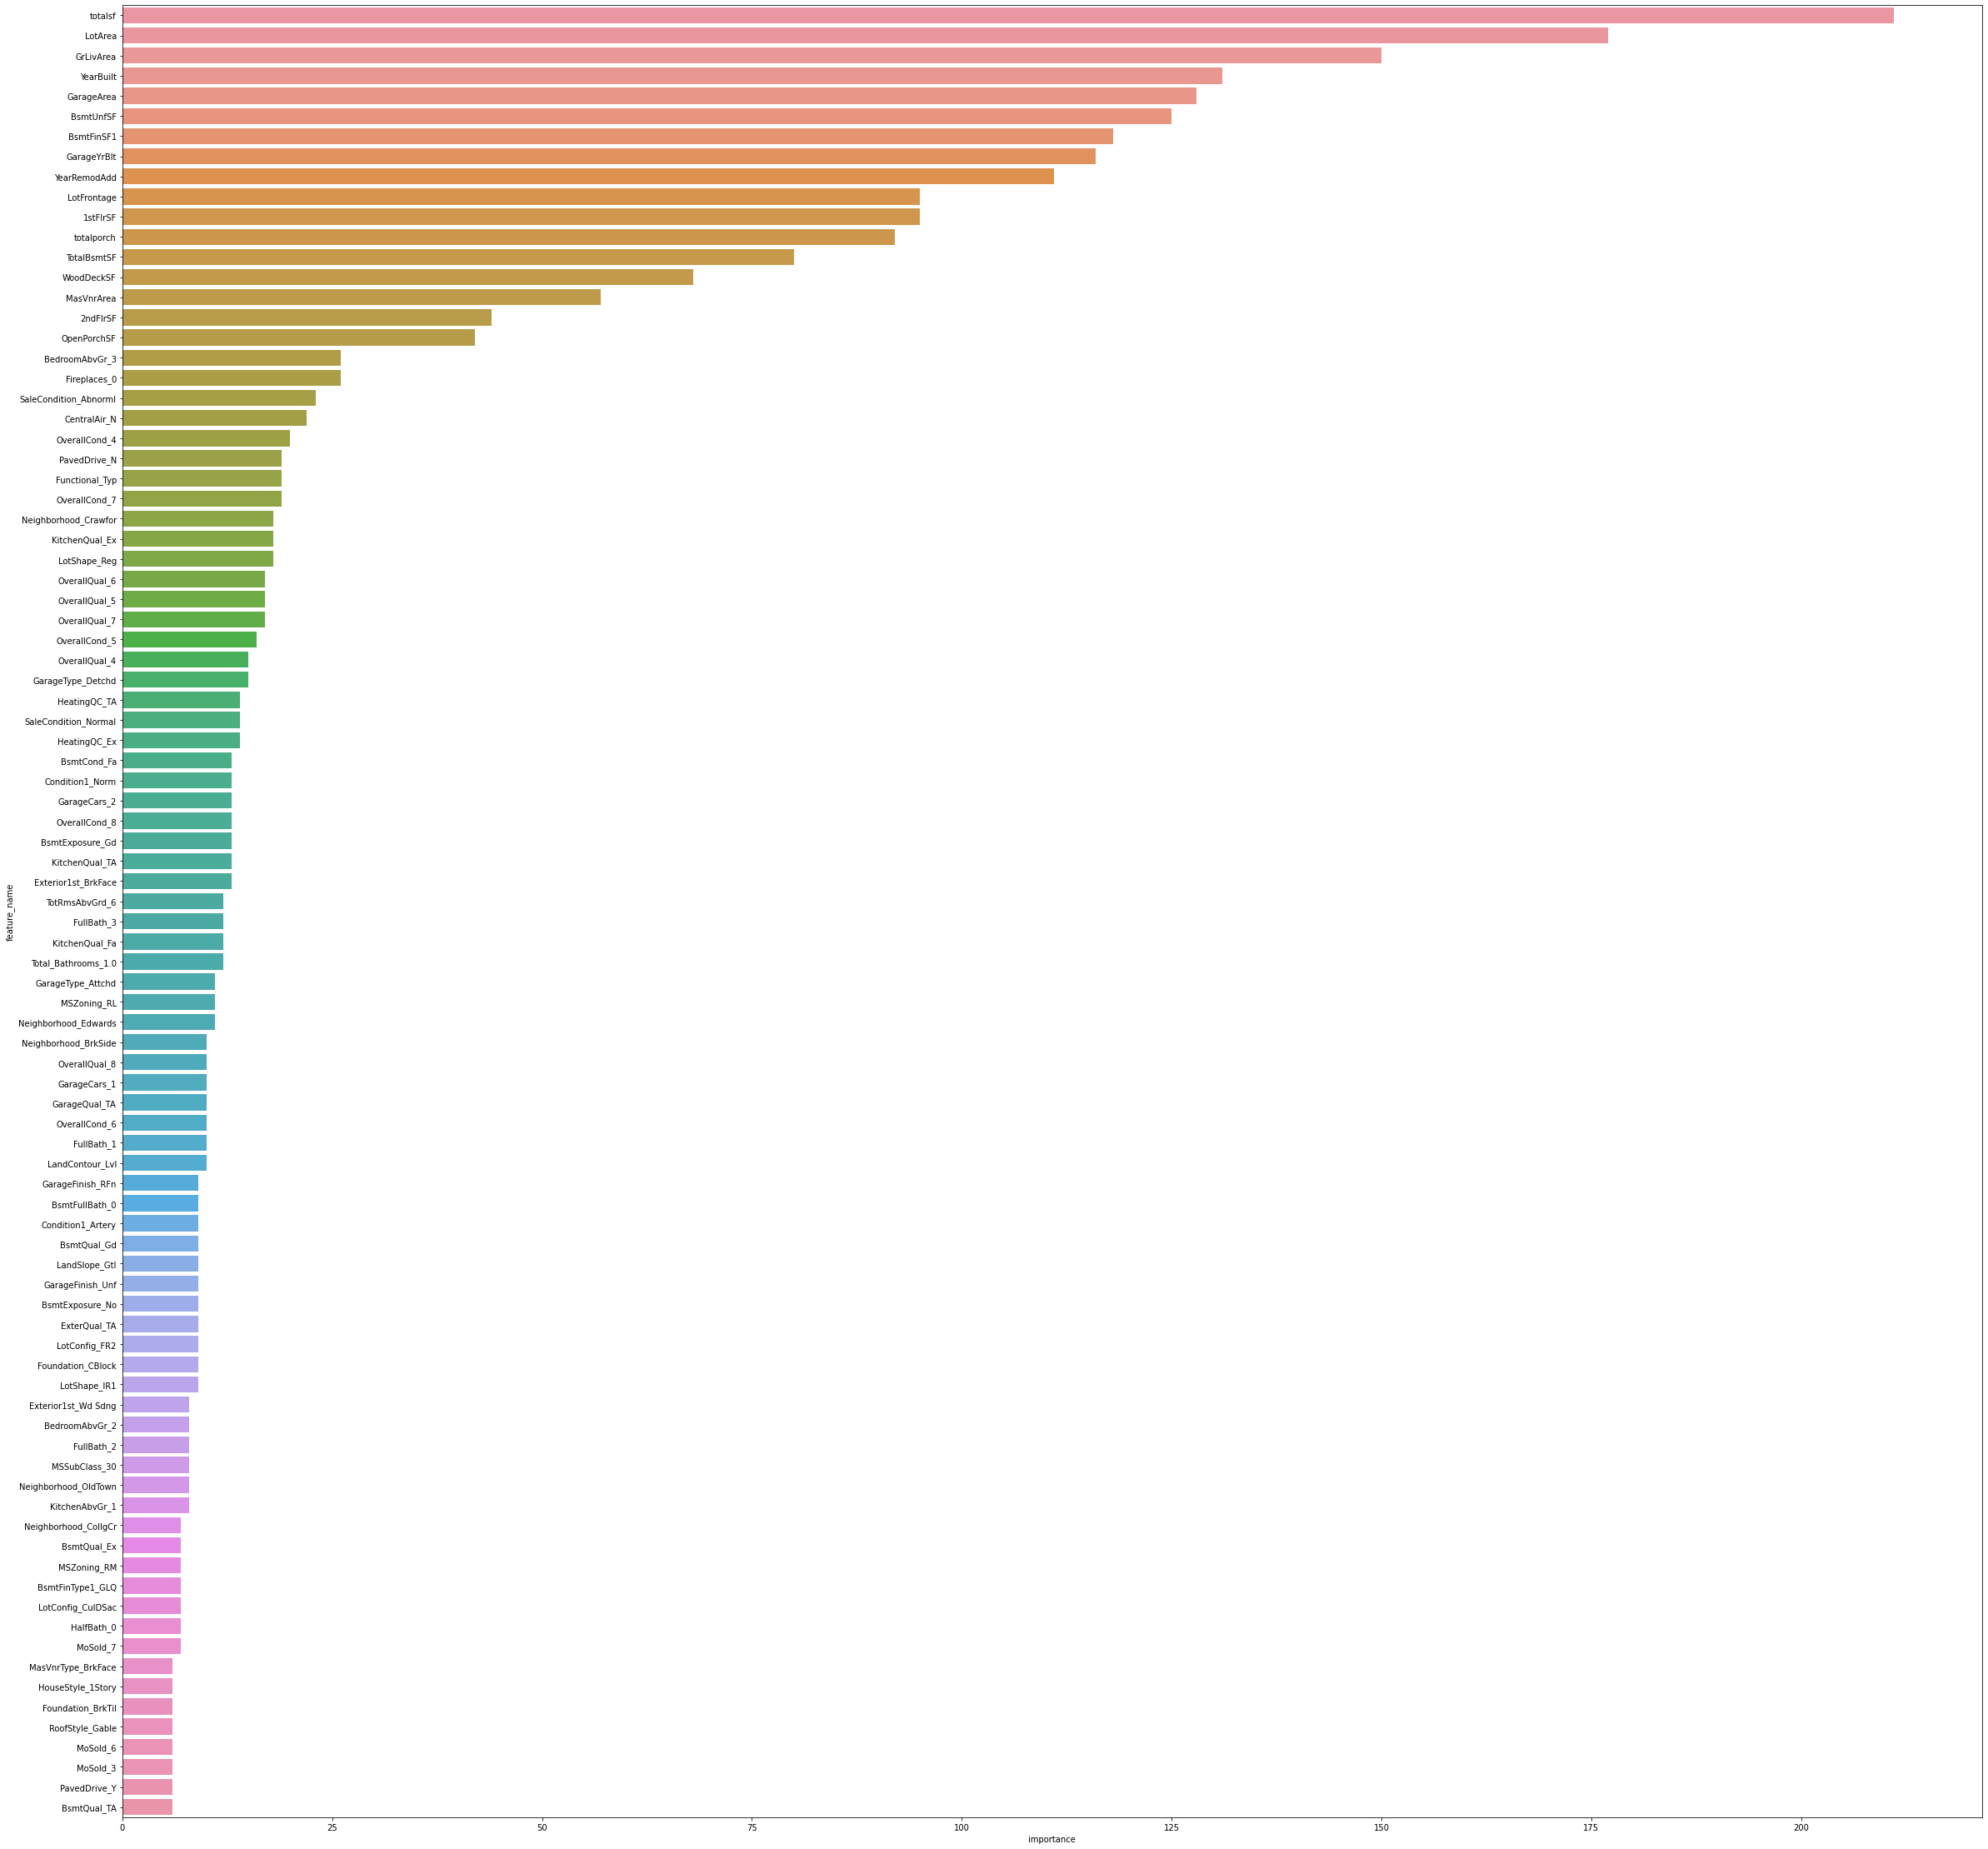

In [78]:
plt.figure(figsize=(40, 40))
sns.barplot(x = 'importance', y = 'feature_name', data = feature_importance[:50])
plt.show()

In [79]:
x_final_select = x[feature_importance.iloc[:final_num, 0]]
x_test_select = test_base[feature_importance.iloc[:final_num, 0]]

In [80]:
def lgb_opt(xtrain, ytrain, trial):
  max_depth = trial.suggest_int('max_depth', 2, 5, 1)
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
  n_estimators = trial.suggest_int('n_estimators', 100, 1000, 100)
  reg_lambda = trial.suggest_float('reg_lambda', 0., 3., step = 0.5)
  reg_alpha = trial.suggest_float('reg_alpha', 0., 3., step = 0.5)
  subsample = trial.suggest_float('subsample', 0.7, 1., step = 0.1)
  colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 1., step = 0.1)
  min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 30, 10)

  lightgbm_opt = lgb.LGBMRegressor(
    random_state = 23,
    verbosity = 1,
    bagging_seed = 0,
    max_depth = max_depth,
    learning_rate = learning_rate,
    n_estimators = n_estimators,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    colsample_bytre = colsample_bytree,
    subsample = subsample,
    min_data_in_leaf = min_data_in_leaf
  )

  kf = KFold(n_splits=5, random_state=23, shuffle=True)
  scores = cross_val_score(lightgbm_opt, xtrain, ytrain, scoring = 'neg_mean_squared_error', cv = kf)
  score = -round(scores.mean(), 5)
  return score

optuna.logging.disable_default_handler()
lb_study = optuna.create_study()
lb_study.optimize(functools.partial(lgb_opt, x_final_select, y_res), n_trials = 50)
print(lb_study.best_value)
print(lb_study.best_params)

0.01106
{'max_depth': 2, 'learning_rate': 0.06785950075813622, 'n_estimators': 700, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_data_in_leaf': 10}


In [81]:
def ran_opt(xtrain, ytrain, trial):
  max_depth = trial.suggest_int('max_depth', 2, 5, 1)
  n_estimators = trial.suggest_int('n_estimators', 100, 1000, 100)
  ccp_alpha = trial.suggest_float('ccp_alpha', 0., 0.5, step = 0.1)
  max_features = trial.suggest_float('max_features', 0.7, 1., step = 0.1)

  ranforest_opt = RandomForestRegressor(
    random_state = 23,
    max_depth = max_depth,
    n_estimators = n_estimators,
    ccp_alpha = ccp_alpha,
    max_features = max_features,
  )

  kf = KFold(n_splits=5, random_state=23, shuffle=True)
  scores = cross_val_score(ranforest_opt, xtrain, ytrain, scoring = 'neg_mean_squared_error', cv = kf)
  score = -round(scores.mean(), 5)
  return score

optuna.logging.disable_default_handler()
ran_study = optuna.create_study()
ran_study.optimize(functools.partial(ran_opt, x_final_select, y_res), n_trials = 50)
print(ran_study.best_value)
print(ran_study.best_params)

0.02345
{'max_depth': 4, 'n_estimators': 500, 'ccp_alpha': 0.0, 'max_features': 0.8999999999999999}


In [82]:
def nn_opt(xtrain, ytrain, trial):
  alpha = trial.suggest_loguniform('alpha', 0.0001, 0.001)
  batch_size = trial.suggest_int('batch_size', 50, 200, 50)
  learning_rate_init = trial.suggest_loguniform('learning_rate_init', 0.001, 0.01)
  beta_1 = trial.suggest_float('beta_1', 0.5, 0.9, step = 0.1)
  beta_2 = trial.suggest_float('beta_2', 0.5, 0.9, step = 0.1)

  mlpreg_opt = MLPRegressor(
    hidden_layer_sizes = (64, 32, 16),
    random_state = 23,
    alpha = alpha,
    batch_size = batch_size,
    learning_rate_init = learning_rate_init,
    beta_1 = beta_1,
    beta_2 = beta_2
  )

  kf = KFold(n_splits=5, random_state=23, shuffle=True)
  scores = cross_val_score(mlpreg_opt, xtrain, ytrain, scoring = 'neg_mean_squared_error', cv = kf)
  score = -round(scores.mean(), 5)
  return score

optuna.logging.disable_default_handler()
nn_study = optuna.create_study()
nn_study.optimize(functools.partial(nn_opt, x_final_select, y_res), n_trials = 50)
print(nn_study.best_value)
print(nn_study.best_params)

0.0348
{'alpha': 0.0004555360624763031, 'batch_size': 50, 'learning_rate_init': 0.004778676855681308, 'beta_1': 0.9, 'beta_2': 0.7}


In [83]:
estimators = [
    ('lgb', lgb.LGBMRegressor(max_depth = 2, learning_rate = 0.0568, n_estimators = 500, reg_lambda = 1.0, reg_alpha = 0.0,
                  subsample = 0.9, colsample_bytree = 1.0, min_data_in_leaf = 10)),
    ('ranforest', RandomForestRegressor(max_depth = 5, n_estimators = 600, ccp_alpha = 0.0, max_features = 0.9)),
    ('nn', MLPRegressor(alpha = 0.00088, batch_size = 100, learning_rate_init = 0.00257, beta_1 = 0.9, beta_2 = 0.6))
]

reg = StackingRegressor(
    estimators = estimators,
    final_estimator = LinearRegression(),
    passthrough = True
)

kf = KFold(n_splits=5, random_state=23, shuffle=True)
scores = cross_val_score(reg, x_final_select, y, scoring = 'neg_mean_squared_error', cv = kf)
score = -round(scores.mean(), 5)
print(score)

0.01104


In [87]:
reg.fit(x_final_select, y)
ypred = reg.predict(x_test_select)

print(round(mean_absolute_percentage_error(np.expm1(ypred), ytest), 5))
print(round(mean_squared_error(np.expm1(ypred), ytest), 5))
print(round(mean_absolute_error(np.expm1(ypred), ytest), 5))

0.08253
514413829.55935
14839.87581
